In [2]:
# 基本庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os

# Darts - 時間序列相關庫
import darts
from darts import TimeSeries, concatenate
from darts.models import (
    DLinearModel, LightGBMModel, BlockRNNModel, TiDEModel, 
    Prophet, AutoARIMA, ARIMA
)
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics.metrics import mape, mae, mse, ape
from darts.logging import get_logger, raise_log, raise_if_not

# Scikit-learn - 數據預處理
from sklearn.preprocessing import MinMaxScaler
from tools.callbacks import LossLoggingCallback
from tools.calculate_95_ci import calculate_95_ci
from tools.calculate_metrics import calculate_metrics
from tools.data_loader import load_and_preprocess_data

import torch
import torch.optim as optim

In [3]:
print(torch.cuda.is_available())  # 如果結果是 True，表示 GPU 可用

True


In [4]:
location = 'Taipei' 
model_type = 'LSTM' 
location_params = {
    'Linkou': {'train_end': 3362, 'val_end': 3727},
    'Taipei': {'train_end': 3372, 'val_end': 3737},
    'Kaohsiung': {'train_end': 3208, 'val_end': 3573},
    'Keelung': {'train_end': 3274, 'val_end': 3639},
    'Yunlin': {'train_end': 2557, 'val_end': 2922},
    'Chiayi': {'train_end': 3237, 'val_end': 3602}
}

#Data preprocess

In [6]:
train_series_scaled, test_series_scaled, combined_series_scaled, train_series, test_series, combined_series, ED_covariates, scaler = load_and_preprocess_data(location)

#Model

In [8]:
loss_logging_callback = LossLoggingCallback()
model = BlockRNNModel(
    model='LSTM',
    input_chunk_length=30,
    output_chunk_length=7,
    hidden_dim= 365,
    dropout=0.5588959956538373,
    n_rnn_layers=1,
    optimizer_cls=optim.Adam,  # 使用 Adam 优化器
    optimizer_kwargs={"lr":  0.001429809099151432}, 
    batch_size=128,
    #save_checkpoints=True,
    pl_trainer_kwargs = {
    "max_epochs": 15,
    "accelerator": "gpu",  # 使用 GPU
    "devices": [0],  # 指定 GPU 設備
    "callbacks": [loss_logging_callback]},)

In [9]:
forecast_horizon =7         
retrain = 1
stride = 7
train_length = location_params[location]['train_end']

# Assuming 'test_series' and 'ED_covariates' are properly defined Darts TimeSeries objects
# Perform the historical forecast
backtest_series = model.historical_forecasts(
    series=combined_series_scaled,
    past_covariates=ED_covariates,
    forecast_horizon=forecast_horizon,
    stride=stride,
    retrain=retrain,
    start=pd.Timestamp('2018-01-01'),
    train_length = train_length,
    last_points_only=False,
    verbose=True,
)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/247 [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion    

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008595817936527722
Epoch 1: train_loss=0.007652612407848617
Epoch 2: train_loss=0.011929716854944735
Epoch 3: train_loss=0.006677401523281637
Epoch 4: train_loss=0.005065331391876058
Epoch 5: train_loss=0.002167013720113221
Epoch 6: train_loss=0.0012429154556671243
Epoch 7: train_loss=0.003500490070419868
Epoch 8: train_loss=0.002137581938833609
Epoch 9: train_loss=0.0036540959246071196
Epoch 10: train_loss=0.0036476167768320234
Epoch 11: train_loss=0.00516768187711002
Epoch 12: train_loss=0.0022678985561432963
Epoch 13: train_loss=0.0015329937946186704


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002534641368464971


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0069743611535597605
Epoch 1: train_loss=0.019437632392043054
Epoch 2: train_loss=0.015043745587325744
Epoch 3: train_loss=0.0028606896418939603
Epoch 4: train_loss=0.003010152307785326
Epoch 5: train_loss=0.027798619479876024
Epoch 6: train_loss=0.003658225414558875
Epoch 7: train_loss=0.002982901282156736
Epoch 8: train_loss=0.0024193671118607402
Epoch 9: train_loss=0.0022580815674571168
Epoch 10: train_loss=0.0020709076842461162
Epoch 11: train_loss=0.0019448510566068044
Epoch 12: train_loss=0.0033407209629982377
Epoch 13: train_loss=0.00205818574739397


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001997431915661266


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.013251856599845421
Epoch 1: train_loss=0.010622051331926376
Epoch 2: train_loss=0.007393881308556538
Epoch 3: train_loss=0.002260066377767304
Epoch 4: train_loss=0.002498285381663627
Epoch 5: train_loss=0.0072959538290107645
Epoch 6: train_loss=0.0034592950355098965
Epoch 7: train_loss=0.006330405245013762
Epoch 8: train_loss=0.00242351790562383
Epoch 9: train_loss=0.02414400755900213
Epoch 10: train_loss=0.002437493716069017
Epoch 11: train_loss=0.003000108079557436
Epoch 12: train_loss=0.002169807656649374
Epoch 13: train_loss=0.0021163761068356836


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003564834031260218


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004954344907448153
Epoch 1: train_loss=0.0054522811677140725
Epoch 2: train_loss=0.00513362092994424
Epoch 3: train_loss=0.002869835131159036
Epoch 4: train_loss=0.0019409039126570854
Epoch 5: train_loss=0.0027477235090727493
Epoch 6: train_loss=0.002350649297689748
Epoch 7: train_loss=0.005673086473880668
Epoch 8: train_loss=0.0035974001390573244
Epoch 9: train_loss=0.0026897746105921543
Epoch 10: train_loss=0.0028940618264472946
Epoch 11: train_loss=0.002011605627385007
Epoch 12: train_loss=0.0018767569846873274
Epoch 13: train_loss=0.0033057912541966917


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0029069921780428627


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003598014235580073
Epoch 1: train_loss=0.007581770444760283
Epoch 2: train_loss=0.00407090491588847
Epoch 3: train_loss=0.022335749951954205
Epoch 4: train_loss=0.0031169747708485835
Epoch 5: train_loss=0.013008754162580578
Epoch 6: train_loss=0.0018553460911731909
Epoch 7: train_loss=0.0025203360316959295
Epoch 8: train_loss=0.004962955170149568
Epoch 9: train_loss=0.004396377293309464
Epoch 10: train_loss=0.003331746061502051
Epoch 11: train_loss=0.004357162005969299
Epoch 12: train_loss=0.0021883261821701375
Epoch 13: train_loss=0.0014812162559258851


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017172863892646972


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009147296489524595
Epoch 1: train_loss=0.006197684311962855
Epoch 2: train_loss=0.01864235225583597
Epoch 3: train_loss=0.002848029287469829
Epoch 4: train_loss=0.006066503668074793
Epoch 5: train_loss=0.005805636706280738
Epoch 6: train_loss=0.001894720349675767
Epoch 7: train_loss=0.0018672818522036511
Epoch 8: train_loss=0.002104800519682064
Epoch 9: train_loss=0.0030762717560662406
Epoch 10: train_loss=0.005163055801717172
Epoch 11: train_loss=0.0021911565305236637
Epoch 12: train_loss=0.004260441448629792
Epoch 13: train_loss=0.0042831082821760125


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004407728484225184


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006938691744280136
Epoch 1: train_loss=0.0044296269800160595
Epoch 2: train_loss=0.00795641115382898
Epoch 3: train_loss=0.004553404725046679
Epoch 4: train_loss=0.0032082015321397784
Epoch 5: train_loss=0.005954513196564642
Epoch 6: train_loss=0.0021414655603911393
Epoch 7: train_loss=0.004652883521472992
Epoch 8: train_loss=0.003392802406901401
Epoch 9: train_loss=0.0018180621563546756
Epoch 10: train_loss=0.0021606084749782165
Epoch 11: train_loss=0.0025050892348490866
Epoch 12: train_loss=0.0029484524258842496
Epoch 13: train_loss=0.003080812945537653


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003163977548831568


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007592264374820038
Epoch 1: train_loss=0.004638415088952574
Epoch 2: train_loss=0.006736728469298698
Epoch 3: train_loss=0.003018065335378723
Epoch 4: train_loss=0.0027682403303787234
Epoch 5: train_loss=0.0016202161851267688
Epoch 6: train_loss=0.0013571109420601158
Epoch 7: train_loss=0.003707739857942178
Epoch 8: train_loss=0.005284148363465406
Epoch 9: train_loss=0.010196815010141622
Epoch 10: train_loss=0.002478506437621191
Epoch 11: train_loss=0.0028736956689767415
Epoch 12: train_loss=0.002312494875203769
Epoch 13: train_loss=0.010158685387238395


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019392856035527462


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004737980910325585
Epoch 1: train_loss=0.008656082814076088
Epoch 2: train_loss=0.004667533655990548
Epoch 3: train_loss=0.004863668049274916
Epoch 4: train_loss=0.01794084705704397
Epoch 5: train_loss=0.003394281331778827
Epoch 6: train_loss=0.01667552579737325
Epoch 7: train_loss=0.01467175445261246
Epoch 8: train_loss=0.00607799040500373
Epoch 9: train_loss=0.00163627140085147
Epoch 10: train_loss=0.0042313305262270725
Epoch 11: train_loss=0.0024539869555090603
Epoch 12: train_loss=0.002680075075648991
Epoch 13: train_loss=0.0025662373242047788


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004763866232404097


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0076518412705706956
Epoch 1: train_loss=0.004126479136940392
Epoch 2: train_loss=0.00330053402854274
Epoch 3: train_loss=0.012135216080683
Epoch 4: train_loss=0.006751486722100694
Epoch 5: train_loss=0.0020048162855453725
Epoch 6: train_loss=0.005798279706226451
Epoch 7: train_loss=0.0024063537433342825
Epoch 8: train_loss=0.0021319528125647636
Epoch 9: train_loss=0.0019706170217483497
Epoch 10: train_loss=0.0013439680017393876
Epoch 11: train_loss=0.0009225619537634796
Epoch 12: train_loss=0.002373456405817998
Epoch 13: train_loss=0.007141672535817283


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003257548579931658


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009623826070089575
Epoch 1: train_loss=0.00955916914250874
Epoch 2: train_loss=0.028256673792705734
Epoch 3: train_loss=0.006447211359580422
Epoch 4: train_loss=0.0032974509561093874
Epoch 5: train_loss=0.003226453971677698
Epoch 6: train_loss=0.0025387058198281815
Epoch 7: train_loss=0.004893080221219428
Epoch 8: train_loss=0.0032580286116476163
Epoch 9: train_loss=0.0020742021522243345
Epoch 10: train_loss=0.0019731334039333978
Epoch 11: train_loss=0.001429528477172265
Epoch 12: train_loss=0.0011485750004881043
Epoch 13: train_loss=0.005597981807079471


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0038414823919977244


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0038981505169352355
Epoch 1: train_loss=0.0046772612124569984
Epoch 2: train_loss=0.011026754371656516
Epoch 3: train_loss=0.004153420758758583
Epoch 4: train_loss=0.0038060513147868064
Epoch 5: train_loss=0.0035885581654901905
Epoch 6: train_loss=0.005863974120578933
Epoch 7: train_loss=0.003493685710966575
Epoch 8: train_loss=0.0030185445951841617
Epoch 9: train_loss=0.0021472363801432106
Epoch 10: train_loss=0.0016215736052036605
Epoch 11: train_loss=0.003840994983955866
Epoch 12: train_loss=0.002321175918790734
Epoch 13: train_loss=0.0021137773963227475


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001072320886626497


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0038453468263015826
Epoch 1: train_loss=0.005505646752721245
Epoch 2: train_loss=0.0032444866614228258
Epoch 3: train_loss=0.004965383708559695
Epoch 4: train_loss=0.0011583955562485208
Epoch 5: train_loss=0.0017425723406598343
Epoch 6: train_loss=0.004265384471986128
Epoch 7: train_loss=0.001657823509830941
Epoch 8: train_loss=0.0024561010451694537
Epoch 9: train_loss=0.005025695832077473
Epoch 10: train_loss=0.0018201408316146097
Epoch 11: train_loss=0.0026444432853255056
Epoch 12: train_loss=0.0028718007924197365
Epoch 13: train_loss=0.0024642898085291388


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017408686969638655


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006280805828781976
Epoch 1: train_loss=0.007059721278870088
Epoch 2: train_loss=0.003654616096224838
Epoch 3: train_loss=0.002770030842226561
Epoch 4: train_loss=0.0032064378604554854
Epoch 5: train_loss=0.0021126754349152913
Epoch 6: train_loss=0.0029315647674273003
Epoch 7: train_loss=0.0016084448716893432
Epoch 8: train_loss=0.002737962113768912
Epoch 9: train_loss=0.002737566075038993
Epoch 10: train_loss=0.0026409209142784097
Epoch 11: train_loss=0.001192023649709989
Epoch 12: train_loss=0.002537723006981782
Epoch 13: train_loss=0.0015560092119911825


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025872651557074986


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006910680897065305
Epoch 1: train_loss=0.01060971662098995
Epoch 2: train_loss=0.002075328686488842
Epoch 3: train_loss=0.004379500907317734
Epoch 4: train_loss=0.0017449334042756387
Epoch 5: train_loss=0.003296144890006606
Epoch 6: train_loss=0.0055873171716439825
Epoch 7: train_loss=0.0014957042000763162
Epoch 8: train_loss=0.0027986425843853757
Epoch 9: train_loss=0.004999871999451147
Epoch 10: train_loss=0.0030219202051268252
Epoch 11: train_loss=0.0013610143179767005
Epoch 12: train_loss=0.0029779913559096123
Epoch 13: train_loss=0.004312829009330249


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013936746570351835


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.026257717379677865
Epoch 1: train_loss=0.005893024335217484
Epoch 2: train_loss=0.010058967153721328
Epoch 3: train_loss=0.007506665327733033
Epoch 4: train_loss=0.004563806438420153
Epoch 5: train_loss=0.0031740749200490116
Epoch 6: train_loss=0.0018656551996266563
Epoch 7: train_loss=0.007126535280101628
Epoch 8: train_loss=0.011466060418114925
Epoch 9: train_loss=0.0023055445385102495
Epoch 10: train_loss=0.008322844223941668
Epoch 11: train_loss=0.002923304841483326
Epoch 12: train_loss=0.0046362902669186525
Epoch 13: train_loss=0.0017080327858104809


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0029858124103502946


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006262417322909721
Epoch 1: train_loss=0.004067548162866141
Epoch 2: train_loss=0.003181978917011187
Epoch 3: train_loss=0.0026581892063283416
Epoch 4: train_loss=0.0022303991334164616
Epoch 5: train_loss=0.011595796523502264
Epoch 6: train_loss=0.0026658248341335485
Epoch 7: train_loss=0.0027500450310270954
Epoch 8: train_loss=0.0012728146919022472
Epoch 9: train_loss=0.0013737527457089176
Epoch 10: train_loss=0.002627076239876791
Epoch 11: train_loss=0.0016392740710670403
Epoch 12: train_loss=0.001494095779645621
Epoch 13: train_loss=0.0029345015548819004


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015017777182662357


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009278252843712765
Epoch 1: train_loss=0.006212984662965397
Epoch 2: train_loss=0.0033681367641663572
Epoch 3: train_loss=0.004579118199477262
Epoch 4: train_loss=0.004761905877977539
Epoch 5: train_loss=0.0049892022660467964
Epoch 6: train_loss=0.0023499606084152057
Epoch 7: train_loss=0.009878405561109485
Epoch 8: train_loss=0.008171119726657653
Epoch 9: train_loss=0.0029447018100218934
Epoch 10: train_loss=0.0013205073416699294
Epoch 11: train_loss=0.004711722953015506
Epoch 12: train_loss=0.0011138094276274579
Epoch 13: train_loss=0.004744037247302984


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014079916929331236


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006163741679324558
Epoch 1: train_loss=0.005585518383479299
Epoch 2: train_loss=0.007357855976696737
Epoch 3: train_loss=0.0020151184661187406
Epoch 4: train_loss=0.0018872600500035252
Epoch 5: train_loss=0.005461134688955354
Epoch 6: train_loss=0.0013806477710477246
Epoch 7: train_loss=0.0036623815247063523
Epoch 8: train_loss=0.0024115721986968466
Epoch 9: train_loss=0.0021586335533988125
Epoch 10: train_loss=0.004474684389542469
Epoch 11: train_loss=0.003255443195024046
Epoch 12: train_loss=0.0024895742076193332
Epoch 13: train_loss=0.0011373785211728968


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003235297724715146


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009613709925137036
Epoch 1: train_loss=0.0031355476830907157
Epoch 2: train_loss=0.004456297967861605
Epoch 3: train_loss=0.004976298983362578
Epoch 4: train_loss=0.017554592196708147
Epoch 5: train_loss=0.0017673278158803435
Epoch 6: train_loss=0.004378660404038909
Epoch 7: train_loss=0.0018959360495566472
Epoch 8: train_loss=0.0022933658203716976
Epoch 9: train_loss=0.0018463673922116872
Epoch 10: train_loss=0.001970153450685987
Epoch 11: train_loss=0.001493656375347754
Epoch 12: train_loss=0.002003066618165611
Epoch 13: train_loss=0.003381710758161213


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003683282428747959


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008943588427653422
Epoch 1: train_loss=0.0028132661683891516
Epoch 2: train_loss=0.004393115675192348
Epoch 3: train_loss=0.006678217353366396
Epoch 4: train_loss=0.007344746949867174
Epoch 5: train_loss=0.003905142942305323
Epoch 6: train_loss=0.0025886189273648668
Epoch 7: train_loss=0.0020307758673798804
Epoch 8: train_loss=0.0017379633528823136
Epoch 9: train_loss=0.0012978674308942806
Epoch 10: train_loss=0.0012702226049117185
Epoch 11: train_loss=0.004003114121688727
Epoch 12: train_loss=0.0024668775159284147
Epoch 13: train_loss=0.0033993918212738444


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002178836816747745


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0034204880190179315
Epoch 1: train_loss=0.004926526898803407
Epoch 2: train_loss=0.024590479015339083
Epoch 3: train_loss=0.0027901071926732138
Epoch 4: train_loss=0.0029398863419063345
Epoch 5: train_loss=0.003763261660080631
Epoch 6: train_loss=0.004348536739279301
Epoch 7: train_loss=0.006861688157052584
Epoch 8: train_loss=0.0018911692611459487
Epoch 9: train_loss=0.002376356362727374
Epoch 10: train_loss=0.00153561025818663
Epoch 11: train_loss=0.004783848533007617
Epoch 12: train_loss=0.0018891829647197467
Epoch 13: train_loss=0.002246294426997623


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016298324052388046


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003981480259375545
Epoch 1: train_loss=0.003731133987663622
Epoch 2: train_loss=0.003326054964803227
Epoch 3: train_loss=0.00649289726514529
Epoch 4: train_loss=0.009223467457720309
Epoch 5: train_loss=0.004639300409179245
Epoch 6: train_loss=0.005216280812498205
Epoch 7: train_loss=0.0017655357224831234
Epoch 8: train_loss=0.0032774203460592577
Epoch 9: train_loss=0.004860718054876417
Epoch 10: train_loss=0.0020661625525903436
Epoch 11: train_loss=0.0017425771436085456
Epoch 12: train_loss=0.0034186021139908282
Epoch 13: train_loss=0.0012829322925963019


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015673621015271182


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004134104176297398
Epoch 1: train_loss=0.0028190690708331085
Epoch 2: train_loss=0.0016245077377836398
Epoch 3: train_loss=0.004339473450704566
Epoch 4: train_loss=0.0018758322269637093
Epoch 5: train_loss=0.0023873726126052053
Epoch 6: train_loss=0.0022129105385045333
Epoch 7: train_loss=0.003322008232263566
Epoch 8: train_loss=0.0025331571091531152
Epoch 9: train_loss=0.0024726325554042666
Epoch 10: train_loss=0.0014090581782212133
Epoch 11: train_loss=0.010506247497558284
Epoch 12: train_loss=0.003223844184756519
Epoch 13: train_loss=0.0031744746249129153


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.011062444363994383


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005201761456533839
Epoch 1: train_loss=0.003963231085585813
Epoch 2: train_loss=0.005239143847021816
Epoch 3: train_loss=0.003062066476328337
Epoch 4: train_loss=0.009910982514898711
Epoch 5: train_loss=0.011323434010736405
Epoch 6: train_loss=0.0021989249416300024
Epoch 7: train_loss=0.004422309301645302
Epoch 8: train_loss=0.018316224958027993
Epoch 9: train_loss=0.001611047118175831
Epoch 10: train_loss=0.001756725975639531
Epoch 11: train_loss=0.013613872042127582
Epoch 12: train_loss=0.0037496207731975576
Epoch 13: train_loss=0.0024902092535303644


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002930397207466552


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00479070555820747
Epoch 1: train_loss=0.007294779971862626
Epoch 2: train_loss=0.0030069336887499775
Epoch 3: train_loss=0.0016015789863825926
Epoch 4: train_loss=0.0029976011438146363
Epoch 5: train_loss=0.0017251888397051623
Epoch 6: train_loss=0.002819814542730525
Epoch 7: train_loss=0.0017368744224017085
Epoch 8: train_loss=0.0018442604735063727
Epoch 9: train_loss=0.00212310631606392
Epoch 10: train_loss=0.0022588981847491358
Epoch 11: train_loss=0.001886758378303053
Epoch 12: train_loss=0.0011020497224434914
Epoch 13: train_loss=0.0024451989306891312


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026498688472509713


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012857031417392894
Epoch 1: train_loss=0.03505362428295008
Epoch 2: train_loss=0.00405933385691224
Epoch 3: train_loss=0.0035158091920287774
Epoch 4: train_loss=0.011678340812475806
Epoch 5: train_loss=0.004701295723977342
Epoch 6: train_loss=0.0021660306015763003
Epoch 7: train_loss=0.0021063303357987833
Epoch 8: train_loss=0.002210968703549107
Epoch 9: train_loss=0.0017038922391236513
Epoch 10: train_loss=0.003064118649631921
Epoch 11: train_loss=0.008410057540459549
Epoch 12: train_loss=0.0009533327106994386
Epoch 13: train_loss=0.0022853157124003653


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0045304250478176225


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0023951167220467107
Epoch 1: train_loss=0.005338202098580707
Epoch 2: train_loss=0.00477021814324958
Epoch 3: train_loss=0.003878160953071505
Epoch 4: train_loss=0.011683997058982945
Epoch 5: train_loss=0.005298438463293975
Epoch 6: train_loss=0.0027608565241384274
Epoch 7: train_loss=0.005062305193169351
Epoch 8: train_loss=0.002066255394286443
Epoch 9: train_loss=0.0035813846782314714
Epoch 10: train_loss=0.001986861183197593
Epoch 11: train_loss=0.0053017198949024584
Epoch 12: train_loss=0.0027469797008002716
Epoch 13: train_loss=0.0025341313447102484


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.01247960149113823


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005901832014530893
Epoch 1: train_loss=0.019142740602291448
Epoch 2: train_loss=0.002171169803671298
Epoch 3: train_loss=0.004544012549035393
Epoch 4: train_loss=0.0047107984780050275
Epoch 5: train_loss=0.00216313789184754
Epoch 6: train_loss=0.005600166843216206
Epoch 7: train_loss=0.004256580367025814
Epoch 8: train_loss=0.006061407928099588
Epoch 9: train_loss=0.001850764326652424
Epoch 10: train_loss=0.002334547806286219
Epoch 11: train_loss=0.0021313032551278956
Epoch 12: train_loss=0.0027391475137582243
Epoch 13: train_loss=0.002031126464753468


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018132374526889827


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009608808179332521
Epoch 1: train_loss=0.001999174189360355
Epoch 2: train_loss=0.005358906799633759
Epoch 3: train_loss=0.00393199735713205
Epoch 4: train_loss=0.008636799483733283
Epoch 5: train_loss=0.0029266154700664294
Epoch 6: train_loss=0.0027906407472433636
Epoch 7: train_loss=0.001945275914465868
Epoch 8: train_loss=0.002731294890682296
Epoch 9: train_loss=0.0041194174524079126
Epoch 10: train_loss=0.00321346118388105
Epoch 11: train_loss=0.0015254898468472346
Epoch 12: train_loss=0.001739925114834233
Epoch 13: train_loss=0.002294498216383525


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023747065178865902


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006802830444256468
Epoch 1: train_loss=0.0026493340212852792
Epoch 2: train_loss=0.0036077367627939554
Epoch 3: train_loss=0.009157178336746721
Epoch 4: train_loss=0.02163317080159291
Epoch 5: train_loss=0.0033901799972085402
Epoch 6: train_loss=0.003115362878927884
Epoch 7: train_loss=0.00308539933716644
Epoch 8: train_loss=0.001923402364647775
Epoch 9: train_loss=0.005163784206244671
Epoch 10: train_loss=0.008257468553041542
Epoch 11: train_loss=0.002676549271742908
Epoch 12: train_loss=0.003808178202512722
Epoch 13: train_loss=0.003331444067687281


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023101562213673874


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012591593906287737
Epoch 1: train_loss=0.004525306880408226
Epoch 2: train_loss=0.00733409133268188
Epoch 3: train_loss=0.0026572679777736017
Epoch 4: train_loss=0.010120265396304992
Epoch 5: train_loss=0.002880936203326957
Epoch 6: train_loss=0.003242842481922018
Epoch 7: train_loss=0.0018266848818236118
Epoch 8: train_loss=0.0022702821123849436
Epoch 9: train_loss=0.0016319236544446538
Epoch 10: train_loss=0.002593893332207422
Epoch 11: train_loss=0.002471436045297968
Epoch 12: train_loss=0.0028085385094421362
Epoch 13: train_loss=0.002204068487876828


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003560874000485122


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0038999312373361084
Epoch 1: train_loss=0.0026581116253491977
Epoch 2: train_loss=0.0034331671207169867
Epoch 3: train_loss=0.005986143768689726
Epoch 4: train_loss=0.002338146850457525
Epoch 5: train_loss=0.0018941598467693286
Epoch 6: train_loss=0.0018810133905443637
Epoch 7: train_loss=0.0025327667244602163
Epoch 8: train_loss=0.0021913135261466456
Epoch 9: train_loss=0.003264539477334249
Epoch 10: train_loss=0.0017666128770301276
Epoch 11: train_loss=0.0020034737317230432
Epoch 12: train_loss=0.003595560900721381
Epoch 13: train_loss=0.0017738544411113552


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001749918843713426


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004186674691590269
Epoch 1: train_loss=0.005120845885972786
Epoch 2: train_loss=0.006682113728455071
Epoch 3: train_loss=0.0065275493552117815
Epoch 4: train_loss=0.0033203032025108056
Epoch 5: train_loss=0.0030843594181464823
Epoch 6: train_loss=0.002190687039085892
Epoch 7: train_loss=0.0019398251358181816
Epoch 8: train_loss=0.0031929379047971524
Epoch 9: train_loss=0.0022474125426352634
Epoch 10: train_loss=0.0038451636224805684
Epoch 11: train_loss=0.0017502703156413771
Epoch 12: train_loss=0.0019054096851703756
Epoch 13: train_loss=0.002334613932197483


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014408664562454


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005083171529502824
Epoch 1: train_loss=0.00488304585230276
Epoch 2: train_loss=0.0031812503567459627
Epoch 3: train_loss=0.006302399063914465
Epoch 4: train_loss=0.0014631354374684566
Epoch 5: train_loss=0.022052758311120177
Epoch 6: train_loss=0.003741850284617264
Epoch 7: train_loss=0.0016701316557424517
Epoch 8: train_loss=0.003000502693341368
Epoch 9: train_loss=0.0020763985562162694
Epoch 10: train_loss=0.0033279023335065555
Epoch 11: train_loss=0.002180908756675655
Epoch 12: train_loss=0.0013975781725279756
Epoch 13: train_loss=0.00351120187017941


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021603540643965902


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004222558688940035
Epoch 1: train_loss=0.005845449078877548
Epoch 2: train_loss=0.0042641889626753
Epoch 3: train_loss=0.003134958621309235
Epoch 4: train_loss=0.002870434324990606
Epoch 5: train_loss=0.002408833736235415
Epoch 6: train_loss=0.001632165770214139
Epoch 7: train_loss=0.0016455717770591852
Epoch 8: train_loss=0.0021982237226995708
Epoch 9: train_loss=0.009589103663826683
Epoch 10: train_loss=0.0019935747725562843
Epoch 11: train_loss=0.0018483638626923373
Epoch 12: train_loss=0.008558994967812162
Epoch 13: train_loss=0.0019331574493100879


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025710669695350645


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0030447157693474333
Epoch 1: train_loss=0.0029265448644220523
Epoch 2: train_loss=0.0036617422665121244
Epoch 3: train_loss=0.0036935781523868803
Epoch 4: train_loss=0.004102868553393033
Epoch 5: train_loss=0.004444702642385098
Epoch 6: train_loss=0.0040254003064525605
Epoch 7: train_loss=0.0034305984371539983
Epoch 8: train_loss=0.001952018311827634
Epoch 9: train_loss=0.0015083668721286767
Epoch 10: train_loss=0.0035801846078324165
Epoch 11: train_loss=0.0020924959962735613
Epoch 12: train_loss=0.002712355732916737
Epoch 13: train_loss=0.001789765830154024


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004034339475460692


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007521304993509004
Epoch 1: train_loss=0.006868957738019255
Epoch 2: train_loss=0.0029562755265342667
Epoch 3: train_loss=0.0020875291686568405
Epoch 4: train_loss=0.004247467188267314
Epoch 5: train_loss=0.0041665971414079515
Epoch 6: train_loss=0.0025648648988263337
Epoch 7: train_loss=0.0013777356956153832
Epoch 8: train_loss=0.005670921804561841
Epoch 9: train_loss=0.0010839812382721567
Epoch 10: train_loss=0.0023100568596070904
Epoch 11: train_loss=0.010701121000714828
Epoch 12: train_loss=0.003481148964700664
Epoch 13: train_loss=0.0020044121102415725


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016424591446211596


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011275397941368533
Epoch 1: train_loss=0.014622629326355682
Epoch 2: train_loss=0.004862859694360233
Epoch 3: train_loss=0.005297080631751718
Epoch 4: train_loss=0.003022260804915576
Epoch 5: train_loss=0.00736491510939845
Epoch 6: train_loss=0.003627935480028576
Epoch 7: train_loss=0.0025579280090262126
Epoch 8: train_loss=0.0027720101703248463
Epoch 9: train_loss=0.0013647422853816063
Epoch 10: train_loss=0.0030124722657772583
Epoch 11: train_loss=0.001907506712576268
Epoch 12: train_loss=0.008806681257146266
Epoch 13: train_loss=0.0016423804528353284


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.017930853531216772


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.014427287373815028
Epoch 1: train_loss=0.004549300873082661
Epoch 2: train_loss=0.0033407984502153874
Epoch 3: train_loss=0.003664926050795553
Epoch 4: train_loss=0.002504503935075741
Epoch 5: train_loss=0.0020178370920576442
Epoch 6: train_loss=0.0022419862179131867
Epoch 7: train_loss=0.003766583619258359
Epoch 8: train_loss=0.00276530658408031
Epoch 9: train_loss=0.0023226278296528684
Epoch 10: train_loss=0.017235052563211537
Epoch 11: train_loss=0.0022192202793461058
Epoch 12: train_loss=0.0015452413924758276
Epoch 13: train_loss=0.0036628371884914754


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004897992025842605


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005003780974201996
Epoch 1: train_loss=0.004629062270039855
Epoch 2: train_loss=0.008066998494231292
Epoch 3: train_loss=0.0030364209655624553
Epoch 4: train_loss=0.003846711978799515
Epoch 5: train_loss=0.003368035612745494
Epoch 6: train_loss=0.0030184442509778183
Epoch 7: train_loss=0.0018764881041796629
Epoch 8: train_loss=0.001931353878176892
Epoch 9: train_loss=0.0024264619410828744
Epoch 10: train_loss=0.0021434092773710144
Epoch 11: train_loss=0.002344670591512127
Epoch 12: train_loss=0.0024950954132944474
Epoch 13: train_loss=0.002049569775610165


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020527330475269123


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007762383078759728
Epoch 1: train_loss=0.005215990852648417
Epoch 2: train_loss=0.0022509054941076295
Epoch 3: train_loss=0.001690919409886281
Epoch 4: train_loss=0.003601923289153252
Epoch 5: train_loss=0.002722621001186309
Epoch 6: train_loss=0.0034480651855536854
Epoch 7: train_loss=0.0020174790190849836
Epoch 8: train_loss=0.0016205964300997256
Epoch 9: train_loss=0.0019518350957678753
Epoch 10: train_loss=0.0018152754404127654
Epoch 11: train_loss=0.0012604395749380897
Epoch 12: train_loss=0.0019952371910777144
Epoch 13: train_loss=0.0015788307480458143


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0010416253527891


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012915591355459725
Epoch 1: train_loss=0.007602874402222848
Epoch 2: train_loss=0.023133217861308925
Epoch 3: train_loss=0.0028567105337778333
Epoch 4: train_loss=0.004048703775494455
Epoch 5: train_loss=0.0018817068597637566
Epoch 6: train_loss=0.0017217503799340614
Epoch 7: train_loss=0.0032963206130860643
Epoch 8: train_loss=0.0013937303599342325
Epoch 9: train_loss=0.003897592321482346
Epoch 10: train_loss=0.0024288278967470323
Epoch 11: train_loss=0.006565224011107492
Epoch 12: train_loss=0.001966766250704251
Epoch 13: train_loss=0.0025615293588496847


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017735360580290998


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0049668251318771145
Epoch 1: train_loss=0.005984532299777979
Epoch 2: train_loss=0.0020874917487784337
Epoch 3: train_loss=0.00585452098775647
Epoch 4: train_loss=0.002853669538373836
Epoch 5: train_loss=0.0038888555623941843
Epoch 6: train_loss=0.0013901785621327066
Epoch 7: train_loss=0.01125840792078515
Epoch 8: train_loss=0.0023083267033054693
Epoch 9: train_loss=0.002843123109523033
Epoch 10: train_loss=0.00401919463405209
Epoch 11: train_loss=0.0020445677880902985
Epoch 12: train_loss=0.0024350361295783387
Epoch 13: train_loss=0.010132231235455912


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0012747549305213086


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003031841681054302
Epoch 1: train_loss=0.0042467069996999065
Epoch 2: train_loss=0.0049634249922480755
Epoch 3: train_loss=0.0019785550589088703
Epoch 4: train_loss=0.003333620360661684
Epoch 5: train_loss=0.01194205036118927
Epoch 6: train_loss=0.0026537832326017623
Epoch 7: train_loss=0.005817481300802207
Epoch 8: train_loss=0.0029326038507053696
Epoch 9: train_loss=0.004979000626443914
Epoch 10: train_loss=0.0034760384962846816
Epoch 11: train_loss=0.002416200649648216
Epoch 12: train_loss=0.0016199888570561341
Epoch 13: train_loss=0.0025241953651329073


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0058136560040873055


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011812390418180531
Epoch 1: train_loss=0.0028680847473451856
Epoch 2: train_loss=0.0048792160221622265
Epoch 3: train_loss=0.005436324248570288
Epoch 4: train_loss=0.00412967789785391
Epoch 5: train_loss=0.0024034852494868556
Epoch 6: train_loss=0.0026171294260990564
Epoch 7: train_loss=0.004747830171890962
Epoch 8: train_loss=0.0015950254818258127
Epoch 9: train_loss=0.0030349248077550348
Epoch 10: train_loss=0.0020420220503529147
Epoch 11: train_loss=0.0035759151267452877
Epoch 12: train_loss=0.0037116718759146604
Epoch 13: train_loss=0.0019600121636532304


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002273605801841575


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005627572291244008
Epoch 1: train_loss=0.003159779183619613
Epoch 2: train_loss=0.0070279301443475755
Epoch 3: train_loss=0.0037298623922233085
Epoch 4: train_loss=0.0031749460073980437
Epoch 5: train_loss=0.0033436977804293688
Epoch 6: train_loss=0.0027248244127305553
Epoch 7: train_loss=0.003068612220545215
Epoch 8: train_loss=0.0024557510347223404
Epoch 9: train_loss=0.002078744144067544
Epoch 10: train_loss=0.0020519189123355346
Epoch 11: train_loss=0.009038194204958534
Epoch 12: train_loss=0.005319070735793651
Epoch 13: train_loss=0.004064032424583869


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017890760633555813


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005389976782588508
Epoch 1: train_loss=0.003111814288280276
Epoch 2: train_loss=0.011343388134022017
Epoch 3: train_loss=0.001479595765558883
Epoch 4: train_loss=0.002556195232671241
Epoch 5: train_loss=0.0026114844760965618
Epoch 6: train_loss=0.004543453061519433
Epoch 7: train_loss=0.0020010903117422987
Epoch 8: train_loss=0.007201188853086283
Epoch 9: train_loss=0.0026250286946467322
Epoch 10: train_loss=0.0012141523301875737
Epoch 11: train_loss=0.004037277125314002
Epoch 12: train_loss=0.008445403573320584
Epoch 13: train_loss=0.0031217470717333504


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023814280788671794


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012055328278274125
Epoch 1: train_loss=0.00490231908919701
Epoch 2: train_loss=0.007170880562866129
Epoch 3: train_loss=0.005008970236979578
Epoch 4: train_loss=0.004324843347903455
Epoch 5: train_loss=0.006036757648047448
Epoch 6: train_loss=0.003230708702694894
Epoch 7: train_loss=0.0024080602526042635
Epoch 8: train_loss=0.0022338375025061814
Epoch 9: train_loss=0.0024857973495451256
Epoch 10: train_loss=0.0028407364091266505
Epoch 11: train_loss=0.0021082465000893742
Epoch 12: train_loss=0.0012018717064277166
Epoch 13: train_loss=0.0019358745651879654


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0033583521361738727


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011616247230903256
Epoch 1: train_loss=0.009671183688122226
Epoch 2: train_loss=0.030478649124961066
Epoch 3: train_loss=0.004678839151199131
Epoch 4: train_loss=0.001790838365479116
Epoch 5: train_loss=0.0028185900469337184
Epoch 6: train_loss=0.0040204360930035515
Epoch 7: train_loss=0.0023802039151692733
Epoch 8: train_loss=0.0017536205362824395
Epoch 9: train_loss=0.0013321748754562973
Epoch 10: train_loss=0.0029113422347792008
Epoch 11: train_loss=0.0019419356231669062
Epoch 12: train_loss=0.011356133688416736
Epoch 13: train_loss=0.0028688846929710494


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001847199412407679


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0026068784175946966
Epoch 1: train_loss=0.0032395384471583647
Epoch 2: train_loss=0.013127304472430507
Epoch 3: train_loss=0.002864872759862161
Epoch 4: train_loss=0.0020878098546800814
Epoch 5: train_loss=0.002348878547353712
Epoch 6: train_loss=0.002621246132562733
Epoch 7: train_loss=0.00211388881480058
Epoch 8: train_loss=0.002286916349473896
Epoch 9: train_loss=0.015202246112441397
Epoch 10: train_loss=0.0028164049091616273
Epoch 11: train_loss=0.004093906699778796
Epoch 12: train_loss=0.0036216350858348846
Epoch 13: train_loss=0.002018436295390176


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002627629408654597


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007183385369785469
Epoch 1: train_loss=0.001581275937250311
Epoch 2: train_loss=0.005157050133947934
Epoch 3: train_loss=0.012943328806859023
Epoch 4: train_loss=0.002783497585691375
Epoch 5: train_loss=0.006481948954632867
Epoch 6: train_loss=0.002746105886207654
Epoch 7: train_loss=0.002806195267137295
Epoch 8: train_loss=0.0018229227467338092
Epoch 9: train_loss=0.009420995514598275
Epoch 10: train_loss=0.004036724755979756
Epoch 11: train_loss=0.0016714080641181649
Epoch 12: train_loss=0.0028226995632010155
Epoch 13: train_loss=0.0018671083724823398


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001545469687559278


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00545856014763644
Epoch 1: train_loss=0.002231064678311635
Epoch 2: train_loss=0.005743772820329577
Epoch 3: train_loss=0.0026605741105495116
Epoch 4: train_loss=0.0026864564197142562
Epoch 5: train_loss=0.0033111041523555492
Epoch 6: train_loss=0.001412737568916693
Epoch 7: train_loss=0.0017891223824050477
Epoch 8: train_loss=0.002040397956628061
Epoch 9: train_loss=0.0012382669985305775
Epoch 10: train_loss=0.0020056297151762217
Epoch 11: train_loss=0.00251408464180044
Epoch 12: train_loss=0.0027481374335905483
Epoch 13: train_loss=0.002013642722291578


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001872705608455759


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008216017928614828
Epoch 1: train_loss=0.008093246839740434
Epoch 2: train_loss=0.002530738319965742
Epoch 3: train_loss=0.002990124491713348
Epoch 4: train_loss=0.005507936687223548
Epoch 5: train_loss=0.005492938335183498
Epoch 6: train_loss=0.0027057943455239273
Epoch 7: train_loss=0.002280682889301959
Epoch 8: train_loss=0.00329148625489463
Epoch 9: train_loss=0.002340841632866759
Epoch 10: train_loss=0.0034420039897807347
Epoch 11: train_loss=0.0014466830690901755
Epoch 12: train_loss=0.00830759268524719
Epoch 13: train_loss=0.001497692368693164


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0031302115080739813


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00780668593865757
Epoch 1: train_loss=0.00535621008837532
Epoch 2: train_loss=0.003029552330874868
Epoch 3: train_loss=0.0051072968202476665
Epoch 4: train_loss=0.0028727138750058038
Epoch 5: train_loss=0.005055643052601346
Epoch 6: train_loss=0.0019255202365829208
Epoch 7: train_loss=0.0018948889635544077
Epoch 8: train_loss=0.0031030561407191246
Epoch 9: train_loss=0.00197387041708414
Epoch 10: train_loss=0.0018634168339838875
Epoch 11: train_loss=0.003070078865903777
Epoch 12: train_loss=0.0013833523148347677
Epoch 13: train_loss=0.0021385893910249357


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0039080618848891585


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003193300274994821
Epoch 1: train_loss=0.003773386012757782
Epoch 2: train_loss=0.002433068853860338
Epoch 3: train_loss=0.003688560948786711
Epoch 4: train_loss=0.004176004732559711
Epoch 5: train_loss=0.0023807267636435894
Epoch 6: train_loss=0.004191127462564416
Epoch 7: train_loss=0.0033536261163986418
Epoch 8: train_loss=0.002231960162489093
Epoch 9: train_loss=0.007812290553392485
Epoch 10: train_loss=0.002628405608999134
Epoch 11: train_loss=0.002350200806853883
Epoch 12: train_loss=0.005026289675485831
Epoch 13: train_loss=0.0013764278117028488


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018623346057806394


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007529899052837019
Epoch 1: train_loss=0.0035540632298553918
Epoch 2: train_loss=0.002228193235388853
Epoch 3: train_loss=0.004030434202513107
Epoch 4: train_loss=0.0023538643709693653
Epoch 5: train_loss=0.002706317104179017
Epoch 6: train_loss=0.0033033890293416787
Epoch 7: train_loss=0.006991246755469425
Epoch 8: train_loss=0.002795174004690878
Epoch 9: train_loss=0.0030174572206251144
Epoch 10: train_loss=0.0012942658559197768
Epoch 11: train_loss=0.002559678702063499
Epoch 12: train_loss=0.0016819474030682117
Epoch 13: train_loss=0.0015248958554763409


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017755983303332403


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0045558477968968315
Epoch 1: train_loss=0.0038543824110609643
Epoch 2: train_loss=0.0035228565724454977
Epoch 3: train_loss=0.0022574646593793244
Epoch 4: train_loss=0.0032179784059820637
Epoch 5: train_loss=0.003957754928925917
Epoch 6: train_loss=0.002306934404174112
Epoch 7: train_loss=0.0018697945518899566
Epoch 8: train_loss=0.0031351886245855314
Epoch 9: train_loss=0.0033290910341599194
Epoch 10: train_loss=0.001939658248483185
Epoch 11: train_loss=0.002227180280231331
Epoch 12: train_loss=0.011553500435974353
Epoch 13: train_loss=0.006130739591409418


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0011591123445371778


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004674673663547672
Epoch 1: train_loss=0.00362269159851313
Epoch 2: train_loss=0.001774597418737138
Epoch 3: train_loss=0.002067503887850442
Epoch 4: train_loss=0.004060986984112327
Epoch 5: train_loss=0.01583599585043805
Epoch 6: train_loss=0.0025255219563163067
Epoch 7: train_loss=0.003261049318925008
Epoch 8: train_loss=0.0013801199871119232
Epoch 9: train_loss=0.004732292850982355
Epoch 10: train_loss=0.002512603142770448
Epoch 11: train_loss=0.009604835746041599
Epoch 12: train_loss=0.002010674659538397
Epoch 13: train_loss=0.0017495207879967877


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014985923548999729


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01214348504438004
Epoch 1: train_loss=0.008483405463755223
Epoch 2: train_loss=0.004922063860723732
Epoch 3: train_loss=0.005650668969050831
Epoch 4: train_loss=0.003122823966704477
Epoch 5: train_loss=0.0018367426367583972
Epoch 6: train_loss=0.0023101553919625734
Epoch 7: train_loss=0.001432408555398507
Epoch 8: train_loss=0.009533168710456728
Epoch 9: train_loss=0.001489771182614554
Epoch 10: train_loss=0.002522081305829373
Epoch 11: train_loss=0.0023668351785483513
Epoch 12: train_loss=0.00458664985226634
Epoch 13: train_loss=0.0048246370862399385


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0010479778645706977


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010151214381823993
Epoch 1: train_loss=0.006754094278904726
Epoch 2: train_loss=0.007305089389249912
Epoch 3: train_loss=0.00442809218544613
Epoch 4: train_loss=0.0011187680143615064
Epoch 5: train_loss=0.0026302081006407776
Epoch 6: train_loss=0.002863842259448443
Epoch 7: train_loss=0.002195371058594221
Epoch 8: train_loss=0.0023896503169486827
Epoch 9: train_loss=0.003221959448893248
Epoch 10: train_loss=0.0019972359550813066
Epoch 11: train_loss=0.002296257353512827
Epoch 12: train_loss=0.002893838981000809
Epoch 13: train_loss=0.00826376782672743


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019874021126220953


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004773451976417373
Epoch 1: train_loss=0.0037772291706340295
Epoch 2: train_loss=0.00921152152375661
Epoch 3: train_loss=0.003525335566815592
Epoch 4: train_loss=0.0046280159529342385
Epoch 5: train_loss=0.002162910075861547
Epoch 6: train_loss=0.002308624963961583
Epoch 7: train_loss=0.002059944858502895
Epoch 8: train_loss=0.004563720887086987
Epoch 9: train_loss=0.0038830495168698056
Epoch 10: train_loss=0.003675695964643186
Epoch 11: train_loss=0.0011841436249214893
Epoch 12: train_loss=0.0018676855832148339
Epoch 13: train_loss=0.0020147702385636406


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002454001616758206


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004123429634090843
Epoch 1: train_loss=0.004055171468347745
Epoch 2: train_loss=0.0035915654069345543
Epoch 3: train_loss=0.0018295957999578923
Epoch 4: train_loss=0.005762488195834613
Epoch 5: train_loss=0.001900729274587075
Epoch 6: train_loss=0.002757810695912136
Epoch 7: train_loss=0.003004216799483385
Epoch 8: train_loss=0.003097292407017093
Epoch 9: train_loss=0.011877709965007605
Epoch 10: train_loss=0.010320087347301748
Epoch 11: train_loss=0.008249903193855292
Epoch 12: train_loss=0.035715880700642764
Epoch 13: train_loss=0.0033223032809687894


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001705016738559446


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005999532827944203
Epoch 1: train_loss=0.0029881335777588395
Epoch 2: train_loss=0.002519826643598952
Epoch 3: train_loss=0.002591952344316076
Epoch 4: train_loss=0.002191336747097412
Epoch 5: train_loss=0.003252384482590416
Epoch 6: train_loss=0.0025473446716781476
Epoch 7: train_loss=0.004132430562995586
Epoch 8: train_loss=0.001608760922846735
Epoch 9: train_loss=0.00950498381561481
Epoch 10: train_loss=0.004093181082280518
Epoch 11: train_loss=0.002970212946342426
Epoch 12: train_loss=0.002039565834881898
Epoch 13: train_loss=0.0023435045741111316


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0028975924490656315


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004340836688361513
Epoch 1: train_loss=0.0030746834493959505
Epoch 2: train_loss=0.002395207003664736
Epoch 3: train_loss=0.004611886460246729
Epoch 4: train_loss=0.0016589805306502338
Epoch 5: train_loss=0.005032410132690665
Epoch 6: train_loss=0.002076849522010168
Epoch 7: train_loss=0.0024233966115526535
Epoch 8: train_loss=0.0037443249107047697
Epoch 9: train_loss=0.0029082076742406354
Epoch 10: train_loss=0.037681621307937375
Epoch 11: train_loss=0.0020482064000758244
Epoch 12: train_loss=0.01779784263331302
Epoch 13: train_loss=0.0017853453075757392


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003605303134771107


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009106901673434963
Epoch 1: train_loss=0.003973971561895092
Epoch 2: train_loss=0.0019670943914087257
Epoch 3: train_loss=0.0028577133226265197
Epoch 4: train_loss=0.0026311462250548884
Epoch 5: train_loss=0.0027485596194084063
Epoch 6: train_loss=0.015494084688135458
Epoch 7: train_loss=0.002541186693444398
Epoch 8: train_loss=0.0033953687748698464
Epoch 9: train_loss=0.0024979119287450685
Epoch 10: train_loss=0.01905644081102748
Epoch 11: train_loss=0.0036101811091797573
Epoch 12: train_loss=0.0018218623663972485
Epoch 13: train_loss=0.005892183472565697


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.010930294852895666


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.012662296416934714
Epoch 1: train_loss=0.005430578782797154
Epoch 2: train_loss=0.0024342898032153077
Epoch 3: train_loss=0.0026890628532961706
Epoch 4: train_loss=0.003732544284073954
Epoch 5: train_loss=0.006496703115260534
Epoch 6: train_loss=0.003721635281927969
Epoch 7: train_loss=0.002337308108012506
Epoch 8: train_loss=0.004052537899815123
Epoch 9: train_loss=0.0028154606143736133
Epoch 10: train_loss=0.0025171289289302313
Epoch 11: train_loss=0.001650075445874218
Epoch 12: train_loss=0.0029593486204613274
Epoch 13: train_loss=0.009751199215665087


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002948915674855862


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008212555355095607
Epoch 1: train_loss=0.015327083286296207
Epoch 2: train_loss=0.0029871354477214486
Epoch 3: train_loss=0.004315026336070982
Epoch 4: train_loss=0.006234455366430898
Epoch 5: train_loss=0.0025506554375703387
Epoch 6: train_loss=0.0015984149545021126
Epoch 7: train_loss=0.002539603041271286
Epoch 8: train_loss=0.0017023036504121257
Epoch 9: train_loss=0.004161905441970455
Epoch 10: train_loss=0.003014682800156156
Epoch 11: train_loss=0.0026846126181073755
Epoch 12: train_loss=0.0018557791075333018
Epoch 13: train_loss=0.0030859176042524403


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0012354649149726833


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002327407928224352
Epoch 1: train_loss=0.007216372821420944
Epoch 2: train_loss=0.005539191032579487
Epoch 3: train_loss=0.003567456172100151
Epoch 4: train_loss=0.003587108787904505
Epoch 5: train_loss=0.0030613343115700074
Epoch 6: train_loss=0.003706673750577418
Epoch 7: train_loss=0.002642386421714386
Epoch 8: train_loss=0.0019523179943058864
Epoch 9: train_loss=0.003593918671548577
Epoch 10: train_loss=0.004944464294587784
Epoch 11: train_loss=0.002100921815369938
Epoch 12: train_loss=0.006622187724892551
Epoch 13: train_loss=0.0018216583206494188


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004273101869237738


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0033650882499355445
Epoch 1: train_loss=0.010574472489829812
Epoch 2: train_loss=0.007090242401751242
Epoch 3: train_loss=0.0029305046987909275
Epoch 4: train_loss=0.004097361440160188
Epoch 5: train_loss=0.006653839709084442
Epoch 6: train_loss=0.0031967248623409076
Epoch 7: train_loss=0.0021841198862159153
Epoch 8: train_loss=0.002537184460191818
Epoch 9: train_loss=0.00420599205124177
Epoch 10: train_loss=0.0017499460974446318
Epoch 11: train_loss=0.002094616521675335
Epoch 12: train_loss=0.0020304621089248485
Epoch 13: train_loss=0.004013889016284559


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020886752632172895


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0033190906478690035
Epoch 1: train_loss=0.004085044482524793
Epoch 2: train_loss=0.006135477800818525
Epoch 3: train_loss=0.0027033379731815008
Epoch 4: train_loss=0.003618794257307979
Epoch 5: train_loss=0.004113315660041797
Epoch 6: train_loss=0.00247499593147363
Epoch 7: train_loss=0.0034422858665921294
Epoch 8: train_loss=0.0024922040848631044
Epoch 9: train_loss=0.002500755340960563
Epoch 10: train_loss=0.0015235582664173298
Epoch 11: train_loss=0.0019047588680168339
Epoch 12: train_loss=0.004184082547047188
Epoch 13: train_loss=0.006913178126646847


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020581168725760258


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0038447777888070203
Epoch 1: train_loss=0.007448114473292392
Epoch 2: train_loss=0.002248257374205534
Epoch 3: train_loss=0.01475189354790693
Epoch 4: train_loss=0.003526073089609819
Epoch 5: train_loss=0.002374202584496225
Epoch 6: train_loss=0.0027245376533359938
Epoch 7: train_loss=0.00197552665818063
Epoch 8: train_loss=0.003743902480475652
Epoch 9: train_loss=0.0033180444669296096
Epoch 10: train_loss=0.002555469768778383
Epoch 11: train_loss=0.0048775465592560685
Epoch 12: train_loss=0.0039547210874680975
Epoch 13: train_loss=0.0018675923796709298


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022398366692129956


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005099439579579705
Epoch 1: train_loss=0.003083123881300181
Epoch 2: train_loss=0.003813759352945852
Epoch 3: train_loss=0.0022318143972873887
Epoch 4: train_loss=0.0016242485523504165
Epoch 5: train_loss=0.0025721701337023573
Epoch 6: train_loss=0.002121673130806957
Epoch 7: train_loss=0.0025551918659590723
Epoch 8: train_loss=0.0028688711120937378
Epoch 9: train_loss=0.0017075406665136962
Epoch 10: train_loss=0.003069836944686482
Epoch 11: train_loss=0.0035539030029355105
Epoch 12: train_loss=0.00214351360831706
Epoch 13: train_loss=0.0019668467148633074


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0043250677012529395


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003908638341429092
Epoch 1: train_loss=0.005746290840950316
Epoch 2: train_loss=0.002410189403641166
Epoch 3: train_loss=0.002000195663013791
Epoch 4: train_loss=0.003286759813250235
Epoch 5: train_loss=0.0034318946576026416
Epoch 6: train_loss=0.0021527988911067574
Epoch 7: train_loss=0.0032308786466294565
Epoch 8: train_loss=0.0029011199585103347
Epoch 9: train_loss=0.004710362407611278
Epoch 10: train_loss=0.0023076299737642037
Epoch 11: train_loss=0.004053773760087994
Epoch 12: train_loss=0.002523521491718337
Epoch 13: train_loss=0.001534316352763789


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014271293952523225


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006115704620317757
Epoch 1: train_loss=0.005965936147581162
Epoch 2: train_loss=0.0019508822226449582
Epoch 3: train_loss=0.003293387714606545
Epoch 4: train_loss=0.0021185449558434083
Epoch 5: train_loss=0.0021789183559528355
Epoch 6: train_loss=0.005957331954587165
Epoch 7: train_loss=0.0015001757217697484
Epoch 8: train_loss=0.002632277122224849
Epoch 9: train_loss=0.0018350317873008786
Epoch 10: train_loss=0.0026702800469152106
Epoch 11: train_loss=0.001545526228215402
Epoch 12: train_loss=0.001691740952292545
Epoch 13: train_loss=0.0010544708212699534


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005985904642718791


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004160439317036014
Epoch 1: train_loss=0.005155345464268044
Epoch 2: train_loss=0.003008774938821402
Epoch 3: train_loss=0.013958026830045801
Epoch 4: train_loss=0.004029223437846914
Epoch 5: train_loss=0.002961547353037069
Epoch 6: train_loss=0.0016321399099953704
Epoch 7: train_loss=0.0021041735172415248
Epoch 8: train_loss=0.0012815095786211446
Epoch 9: train_loss=0.004323252111854845
Epoch 10: train_loss=0.003008304566867221
Epoch 11: train_loss=0.00239118259099228
Epoch 12: train_loss=0.0024603778940764987
Epoch 13: train_loss=0.0024422638169489513


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017918067677771734


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010565534891231333
Epoch 1: train_loss=0.006697704418471821
Epoch 2: train_loss=0.0021008776702684455
Epoch 3: train_loss=0.003675598593077564
Epoch 4: train_loss=0.01592114022083266
Epoch 5: train_loss=0.004021585082179025
Epoch 6: train_loss=0.002205041295215119
Epoch 7: train_loss=0.001830359995725507
Epoch 8: train_loss=0.002157217870390896
Epoch 9: train_loss=0.0026467624418339275
Epoch 10: train_loss=0.00134227860840605
Epoch 11: train_loss=0.001301844164998484
Epoch 12: train_loss=0.0040794060831403104
Epoch 13: train_loss=0.0017877455773709747


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0027957658575611475


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003486676020901357
Epoch 1: train_loss=0.0042494458749165135
Epoch 2: train_loss=0.004028424441381681
Epoch 3: train_loss=0.004744731939052591
Epoch 4: train_loss=0.0045220620154073805
Epoch 5: train_loss=0.002587041490069283
Epoch 6: train_loss=0.0037741905688120974
Epoch 7: train_loss=0.002080534172563193
Epoch 8: train_loss=0.004473857427633435
Epoch 9: train_loss=0.0018634733590469671
Epoch 10: train_loss=0.0018994825301040417
Epoch 11: train_loss=0.0025502409521400223
Epoch 12: train_loss=0.0020595232615986028
Epoch 13: train_loss=0.0028671059680711202


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013920018376202433


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009746075365848653
Epoch 1: train_loss=0.0069201703531767255
Epoch 2: train_loss=0.003908411951866333
Epoch 3: train_loss=0.0035063311099929025
Epoch 4: train_loss=0.009914821858299427
Epoch 5: train_loss=0.0027987916622992234
Epoch 6: train_loss=0.0024863985999122313
Epoch 7: train_loss=0.001975995613150394
Epoch 8: train_loss=0.0017130844188351373
Epoch 9: train_loss=0.0013844633149227342
Epoch 10: train_loss=0.003559895559689172
Epoch 11: train_loss=0.002484626577876748
Epoch 12: train_loss=0.0023848887213586594
Epoch 13: train_loss=0.002727921182223923


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015055419438748051


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01036549223232115
Epoch 1: train_loss=0.0020876594701564263
Epoch 2: train_loss=0.0037835957832173094
Epoch 3: train_loss=0.0013703385873008894
Epoch 4: train_loss=0.005148011506023922
Epoch 5: train_loss=0.0025363993914154074
Epoch 6: train_loss=0.002040366313510544
Epoch 7: train_loss=0.005279067787317397
Epoch 8: train_loss=0.001545940741791543
Epoch 9: train_loss=0.0013721735180191959
Epoch 10: train_loss=0.0024355190975085105
Epoch 11: train_loss=0.0021041007252265253
Epoch 12: train_loss=0.001554592422164126
Epoch 13: train_loss=0.001331277921415524


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017876494723786337


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00269479900332054
Epoch 1: train_loss=0.004492299183283202
Epoch 2: train_loss=0.0023634073121557085
Epoch 3: train_loss=0.004126178739604973
Epoch 4: train_loss=0.00403686690470359
Epoch 5: train_loss=0.005639416709126857
Epoch 6: train_loss=0.0012399563211110522
Epoch 7: train_loss=0.003613438116825468
Epoch 8: train_loss=0.0034067184863387865
Epoch 9: train_loss=0.002555465295543728
Epoch 10: train_loss=0.0016214173951625197
Epoch 11: train_loss=0.004187141355146894
Epoch 12: train_loss=0.003525552873498644
Epoch 13: train_loss=0.0015995790580089488


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015786038516921819


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00411847042790071
Epoch 1: train_loss=0.003644681315876217
Epoch 2: train_loss=0.0037161285937840774
Epoch 3: train_loss=0.003659025138311102
Epoch 4: train_loss=0.003165807463677137
Epoch 5: train_loss=0.0025895936825588734
Epoch 6: train_loss=0.002214768467606236
Epoch 7: train_loss=0.0018023611824302581
Epoch 8: train_loss=0.006107379680043627
Epoch 9: train_loss=0.0013420727218529192
Epoch 10: train_loss=0.002442844114459939
Epoch 11: train_loss=0.00196905248809207
Epoch 12: train_loss=0.0022368319239410156
Epoch 13: train_loss=0.0014134914426483015


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022065088490325043


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0034878115295925863
Epoch 1: train_loss=0.002600400042051854
Epoch 2: train_loss=0.004039141377094446
Epoch 3: train_loss=0.003988637686346449
Epoch 4: train_loss=0.0016904433276118055
Epoch 5: train_loss=0.017715916336500267
Epoch 6: train_loss=0.01814821237142903
Epoch 7: train_loss=0.025445951481821286
Epoch 8: train_loss=0.001163566534690431
Epoch 9: train_loss=0.011539584650976709
Epoch 10: train_loss=0.0022364524338599453
Epoch 11: train_loss=0.0016912981078853952
Epoch 12: train_loss=0.0010668350284800227
Epoch 13: train_loss=0.010389913593568325


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0062202597896751045


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006362520485543347
Epoch 1: train_loss=0.007550058525189143
Epoch 2: train_loss=0.00695211246812036
Epoch 3: train_loss=0.0022306370290400383
Epoch 4: train_loss=0.004479180188807998
Epoch 5: train_loss=0.002869901006836451
Epoch 6: train_loss=0.0026611864154073603
Epoch 7: train_loss=0.001898801578858412
Epoch 8: train_loss=0.0031360649373490383
Epoch 9: train_loss=0.0019141275119741378
Epoch 10: train_loss=0.0031456044682287303
Epoch 11: train_loss=0.0013204904277354069
Epoch 12: train_loss=0.001634468322984385
Epoch 13: train_loss=0.0007159697280863988


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018515473625874742


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004961585833941107
Epoch 1: train_loss=0.003607091945202609
Epoch 2: train_loss=0.008353305865400564
Epoch 3: train_loss=0.00422708064380431
Epoch 4: train_loss=0.005432315745402851
Epoch 5: train_loss=0.003624675819963279
Epoch 6: train_loss=0.0018702458507946107
Epoch 7: train_loss=0.0031427895348427066
Epoch 8: train_loss=0.0023722780065115715
Epoch 9: train_loss=0.0037753714725265322
Epoch 10: train_loss=0.0022213598497476013
Epoch 11: train_loss=0.0025241948889726724
Epoch 12: train_loss=0.002954434830074892
Epoch 13: train_loss=0.002733592191794713


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002014347195943044


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003450226214493016
Epoch 1: train_loss=0.0069342344034547705
Epoch 2: train_loss=0.003177310213081643
Epoch 3: train_loss=0.001742731204670051
Epoch 4: train_loss=0.0026423891348486116
Epoch 5: train_loss=0.005052193275733159
Epoch 6: train_loss=0.002197440190108485
Epoch 7: train_loss=0.0025544865112517626
Epoch 8: train_loss=0.0026173728272498326
Epoch 9: train_loss=0.001701189120049731
Epoch 10: train_loss=0.00699785998031733
Epoch 11: train_loss=0.00300641706071642
Epoch 12: train_loss=0.0020848516691671995
Epoch 13: train_loss=0.002916509116336094


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003281289338691351


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011784535186227978
Epoch 1: train_loss=0.010671662547894565
Epoch 2: train_loss=0.005145291107968687
Epoch 3: train_loss=0.0035368843128382264
Epoch 4: train_loss=0.001985664979639948
Epoch 5: train_loss=0.0031716184527330557
Epoch 6: train_loss=0.0018864782960477194
Epoch 7: train_loss=0.0013222750688417554
Epoch 8: train_loss=0.006047742868301586
Epoch 9: train_loss=0.009521612665150714
Epoch 10: train_loss=0.0021576011591075937
Epoch 11: train_loss=0.0012102043176677698
Epoch 12: train_loss=0.0027282925524966858
Epoch 13: train_loss=0.0041170320907057585


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003112013320765011


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006832432932213106
Epoch 1: train_loss=0.0022323538464138286
Epoch 2: train_loss=0.003971018622663663
Epoch 3: train_loss=0.0020066955411772464
Epoch 4: train_loss=0.007705834887530208
Epoch 5: train_loss=0.006368078308839216
Epoch 6: train_loss=0.0027454962377835438
Epoch 7: train_loss=0.0027696588035680246
Epoch 8: train_loss=0.00279643162064787
Epoch 9: train_loss=0.002058461007418954
Epoch 10: train_loss=0.0026650777189921315
Epoch 11: train_loss=0.0020860939748298226
Epoch 12: train_loss=0.0026355822072889196
Epoch 13: train_loss=0.00157891902294112


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014940166010077394


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006659266797364522
Epoch 1: train_loss=0.004538185866747473
Epoch 2: train_loss=0.0024757099933049
Epoch 3: train_loss=0.0022676644675037865
Epoch 4: train_loss=0.004425161945807264
Epoch 5: train_loss=0.003607826291201133
Epoch 6: train_loss=0.00229695507823542
Epoch 7: train_loss=0.0026226502466152545
Epoch 8: train_loss=0.00231076028884086
Epoch 9: train_loss=0.0015814122671295428
Epoch 10: train_loss=0.0015307249571406985
Epoch 11: train_loss=0.0027720245167128198
Epoch 12: train_loss=0.0025409179968840312
Epoch 13: train_loss=0.0013636243485863752


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.008457739710032311


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0032905279568272187
Epoch 1: train_loss=0.005456100559383941
Epoch 2: train_loss=0.003824122550466884
Epoch 3: train_loss=0.01670363943489783
Epoch 4: train_loss=0.002229429301471185
Epoch 5: train_loss=0.0038694184170980795
Epoch 6: train_loss=0.003226693677092059
Epoch 7: train_loss=0.005930271997093946
Epoch 8: train_loss=0.002755076517660375
Epoch 9: train_loss=0.001574496389525635
Epoch 10: train_loss=0.006354605381520003
Epoch 11: train_loss=0.0017897946979291979
Epoch 12: train_loss=0.0015298886595656372
Epoch 13: train_loss=0.009357763878266404


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0032144833016549707


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007830429822569922
Epoch 1: train_loss=0.0043684873643751254
Epoch 2: train_loss=0.004318031859793782
Epoch 3: train_loss=0.001945624767019403
Epoch 4: train_loss=0.0020248270865057083
Epoch 5: train_loss=0.003521572496598617
Epoch 6: train_loss=0.010492530524763092
Epoch 7: train_loss=0.0018841886947535806
Epoch 8: train_loss=0.0032635431835071602
Epoch 9: train_loss=0.004437860825095047
Epoch 10: train_loss=0.0016394821857395538
Epoch 11: train_loss=0.005558674027513138
Epoch 12: train_loss=0.018927475758051527
Epoch 13: train_loss=0.003908445597402094


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022364768500323946


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010367424659771363
Epoch 1: train_loss=0.0027801856985513887
Epoch 2: train_loss=0.0041406504994521785
Epoch 3: train_loss=0.004656380399284757
Epoch 4: train_loss=0.0023364156521294005
Epoch 5: train_loss=0.0025101595179008087
Epoch 6: train_loss=0.002957128451471743
Epoch 7: train_loss=0.0010812622118889165
Epoch 8: train_loss=0.0013672566245300762
Epoch 9: train_loss=0.0025753040225268745
Epoch 10: train_loss=0.0016717303633028105
Epoch 11: train_loss=0.003609625769747661
Epoch 12: train_loss=0.0031523543317149945
Epoch 13: train_loss=0.001183814781539617


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0037068000386690876


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00658605177116151
Epoch 1: train_loss=0.00264928706974154
Epoch 2: train_loss=0.002016549343730562
Epoch 3: train_loss=0.005059356037366656
Epoch 4: train_loss=0.002107717051366033
Epoch 5: train_loss=0.003386140228919236
Epoch 6: train_loss=0.002273130433344938
Epoch 7: train_loss=0.0027316181779585805
Epoch 8: train_loss=0.001614959350695968
Epoch 9: train_loss=0.0021756037807030937
Epoch 10: train_loss=0.0017204990014485333
Epoch 11: train_loss=0.0015104837488852602
Epoch 12: train_loss=0.004297337305078876
Epoch 13: train_loss=0.002246716530369107


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021702547233429423


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0053363271965369925
Epoch 1: train_loss=0.003826083852140054
Epoch 2: train_loss=0.009378801441610062
Epoch 3: train_loss=0.0032392701833793597
Epoch 4: train_loss=0.004164986273148216
Epoch 5: train_loss=0.0016105200365874788
Epoch 6: train_loss=0.002201283279391635
Epoch 7: train_loss=0.0021338980345511683
Epoch 8: train_loss=0.0036827929490988024
Epoch 9: train_loss=0.003402331546018913
Epoch 10: train_loss=0.0031863061043698186
Epoch 11: train_loss=0.0018160814397527396
Epoch 12: train_loss=0.0023644963311188366
Epoch 13: train_loss=0.0027972347553400618


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002576264356085042


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0023413573128763508
Epoch 1: train_loss=0.0053936964545967915
Epoch 2: train_loss=0.007229091790102895
Epoch 3: train_loss=0.0023471286362608174
Epoch 4: train_loss=0.011386133593860655
Epoch 5: train_loss=0.0011309698036617425
Epoch 6: train_loss=0.0033118815385468096
Epoch 7: train_loss=0.0019405244276154776
Epoch 8: train_loss=0.0022298196443552077
Epoch 9: train_loss=0.002157155950730482
Epoch 10: train_loss=0.0030573944313616896
Epoch 11: train_loss=0.00148194314648008
Epoch 12: train_loss=0.0031430606409893085
Epoch 13: train_loss=0.001106248136169984


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00242246462544796


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.016741006909041293
Epoch 1: train_loss=0.003888482527761134
Epoch 2: train_loss=0.004460201845206318
Epoch 3: train_loss=0.0033662514270115574
Epoch 4: train_loss=0.0017797361786337793
Epoch 5: train_loss=0.008917039690833765
Epoch 6: train_loss=0.003159748742974888
Epoch 7: train_loss=0.0036659071729016625
Epoch 8: train_loss=0.00342252149342325
Epoch 9: train_loss=0.0029947004137273444
Epoch 10: train_loss=0.002658664179290435
Epoch 11: train_loss=0.001899642871453996
Epoch 12: train_loss=0.0021767515206294486
Epoch 13: train_loss=0.001737995368315877


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014430248108004873


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0034156129121259396
Epoch 1: train_loss=0.0030184123788646153
Epoch 2: train_loss=0.0034601139471744716
Epoch 3: train_loss=0.004149892387544228
Epoch 4: train_loss=0.002163786945310075
Epoch 5: train_loss=0.0029910628169436473
Epoch 6: train_loss=0.0039448392960568564
Epoch 7: train_loss=0.0020277839992279083
Epoch 8: train_loss=0.0081699222574115
Epoch 9: train_loss=0.006663179483502049
Epoch 10: train_loss=0.002090786073947281
Epoch 11: train_loss=0.0014688542929546752
Epoch 12: train_loss=0.0026549082147000894
Epoch 13: train_loss=0.011501293940309774


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002413571757196881


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003787694143296009
Epoch 1: train_loss=0.0026977332498255954
Epoch 2: train_loss=0.010558879392310478
Epoch 3: train_loss=0.00274877725920246
Epoch 4: train_loss=0.0035726115654356088
Epoch 5: train_loss=0.0028347994863337734
Epoch 6: train_loss=0.0018179564169678148
Epoch 7: train_loss=0.006711813000950445
Epoch 8: train_loss=0.0016304329992528387
Epoch 9: train_loss=0.001723440221726887
Epoch 10: train_loss=0.002539978426645209
Epoch 11: train_loss=0.0014404668936228205
Epoch 12: train_loss=0.002343677190679443
Epoch 13: train_loss=0.0014054235034230713


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0026994549401062684


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006059646127271978
Epoch 1: train_loss=0.0019077533897761565
Epoch 2: train_loss=0.003487813724506102
Epoch 3: train_loss=0.0028198661284842544
Epoch 4: train_loss=0.007384548553169938
Epoch 5: train_loss=0.002113023223585159
Epoch 6: train_loss=0.003719376727157486
Epoch 7: train_loss=0.0025525363299690102
Epoch 8: train_loss=0.0043179175984281795
Epoch 9: train_loss=0.0009484703928067725
Epoch 10: train_loss=0.0022019891603270053
Epoch 11: train_loss=0.0015970085488663723
Epoch 12: train_loss=0.0013249938469401714
Epoch 13: train_loss=0.003203700811329595


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013953578949343769


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.019285847119120486
Epoch 1: train_loss=0.004415719910436683
Epoch 2: train_loss=0.004260535258680538
Epoch 3: train_loss=0.003204463758129459
Epoch 4: train_loss=0.001875372999566397
Epoch 5: train_loss=0.0034061316765860326
Epoch 6: train_loss=0.0024041125136670775
Epoch 7: train_loss=0.007087387935284233
Epoch 8: train_loss=0.0036689980099492685
Epoch 9: train_loss=0.0015921387956490936
Epoch 10: train_loss=0.012591190899086231
Epoch 11: train_loss=0.004382711274314642
Epoch 12: train_loss=0.00315068683558518
Epoch 13: train_loss=0.0017305223413429734


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001303105515357016


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01371956935354566
Epoch 1: train_loss=0.004398765489399087
Epoch 2: train_loss=0.002754762191958725
Epoch 3: train_loss=0.00209347985601427
Epoch 4: train_loss=0.002147555828539795
Epoch 5: train_loss=0.0018344271588015197
Epoch 6: train_loss=0.00182219398936309
Epoch 7: train_loss=0.0020201276634194652
Epoch 8: train_loss=0.0022249249883390626
Epoch 9: train_loss=0.0019969759211890467
Epoch 10: train_loss=0.0010432657176396563
Epoch 11: train_loss=0.001594635907528453
Epoch 12: train_loss=0.0034960400628549155
Epoch 13: train_loss=0.002673267891683351


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0036490573400929155


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005255853902526354
Epoch 1: train_loss=0.0023143282008097096
Epoch 2: train_loss=0.004345741681590188
Epoch 3: train_loss=0.0024589621997936854
Epoch 4: train_loss=0.0026632713306751613
Epoch 5: train_loss=0.001256444707866182
Epoch 6: train_loss=0.004055546405290012
Epoch 7: train_loss=0.0028334937397214515
Epoch 8: train_loss=0.002898136246249534
Epoch 9: train_loss=0.0022698575669365217
Epoch 10: train_loss=0.001412888995233803
Epoch 11: train_loss=0.0014979072985441255
Epoch 12: train_loss=0.0016604854384443728
Epoch 13: train_loss=0.0013286147236564504


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0024449799484496807


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004260332433205385
Epoch 1: train_loss=0.004960560184277796
Epoch 2: train_loss=0.0036152190281486087
Epoch 3: train_loss=0.0038930834871090778
Epoch 4: train_loss=0.0018226749057398653
Epoch 5: train_loss=0.005338628649737155
Epoch 6: train_loss=0.003562176931030031
Epoch 7: train_loss=0.0032111501392832393
Epoch 8: train_loss=0.0032039778711389823
Epoch 9: train_loss=0.0022655910623092385
Epoch 10: train_loss=0.0018056138342828303
Epoch 11: train_loss=0.0020082384653190965
Epoch 12: train_loss=0.0014951220630198263
Epoch 13: train_loss=0.0025283419744771937


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0010828493421850252


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00209441277217372
Epoch 1: train_loss=0.006400543742146809
Epoch 2: train_loss=0.003478074976364273
Epoch 3: train_loss=0.009001179437889958
Epoch 4: train_loss=0.0035746741487253804
Epoch 5: train_loss=0.0017915757423548999
Epoch 6: train_loss=0.004685761681245981
Epoch 7: train_loss=0.001663161544464111
Epoch 8: train_loss=0.0016287600488433017
Epoch 9: train_loss=0.002267259063131213
Epoch 10: train_loss=0.014065982162082666
Epoch 11: train_loss=0.002425129533635868
Epoch 12: train_loss=0.003449686348156142
Epoch 13: train_loss=0.0012069605479807044


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025091308667816916


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005534441684348713
Epoch 1: train_loss=0.0037394122299919275
Epoch 2: train_loss=0.0014319817211822503
Epoch 3: train_loss=0.00541200899126107
Epoch 4: train_loss=0.0020246927716651604
Epoch 5: train_loss=0.001919516684616733
Epoch 6: train_loss=0.003016262785318165
Epoch 7: train_loss=0.0012748899922236212
Epoch 8: train_loss=0.0037036854868065863
Epoch 9: train_loss=0.0025602887256784765
Epoch 10: train_loss=0.012984381517499763
Epoch 11: train_loss=0.0016026878630768667
Epoch 12: train_loss=0.007202671368628754
Epoch 13: train_loss=0.004761711027408514


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014336102689204322


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004947223655144365
Epoch 1: train_loss=0.005272578796643485
Epoch 2: train_loss=0.010543560381831825
Epoch 3: train_loss=0.00256324438847377
Epoch 4: train_loss=0.0034539636770800986
Epoch 5: train_loss=0.008409460369557522
Epoch 6: train_loss=0.0021915712642643424
Epoch 7: train_loss=0.0024385142855233564
Epoch 8: train_loss=0.008832853212551948
Epoch 9: train_loss=0.002887721840285646
Epoch 10: train_loss=0.006649691660006813
Epoch 11: train_loss=0.008306229036704103
Epoch 12: train_loss=0.0012360706381919016
Epoch 13: train_loss=0.0013027444204096272


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014597480253867017


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0025997678332524395
Epoch 1: train_loss=0.003716816342488105
Epoch 2: train_loss=0.003422902426831833
Epoch 3: train_loss=0.013388950882761153
Epoch 4: train_loss=0.002239506381787219
Epoch 5: train_loss=0.0029562470242541715
Epoch 6: train_loss=0.00380658325353838
Epoch 7: train_loss=0.002480386103635927
Epoch 8: train_loss=0.002085013670669324
Epoch 9: train_loss=0.0025085040021302044
Epoch 10: train_loss=0.0017942497392459593
Epoch 11: train_loss=0.0018621673326150209
Epoch 12: train_loss=0.002012954180009343
Epoch 13: train_loss=0.0018041320496862715


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0054900775411113045


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00316419801889256
Epoch 1: train_loss=0.006878260500828898
Epoch 2: train_loss=0.0027464581818704044
Epoch 3: train_loss=0.006388263871065769
Epoch 4: train_loss=0.0019264765357966097
Epoch 5: train_loss=0.002908438604726551
Epoch 6: train_loss=0.0017934599619140734
Epoch 7: train_loss=0.003007501197363157
Epoch 8: train_loss=0.0029261703185150824
Epoch 9: train_loss=0.0017009159463300988
Epoch 10: train_loss=0.002297635996492958
Epoch 11: train_loss=0.002267033510976338
Epoch 12: train_loss=0.003805525127152572
Epoch 13: train_loss=0.003511411030483837


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021837158575482027


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004173739618909986
Epoch 1: train_loss=0.004955014428878353
Epoch 2: train_loss=0.003556812588820558
Epoch 3: train_loss=0.002495037851058871
Epoch 4: train_loss=0.00544821736676224
Epoch 5: train_loss=0.001914838188118248
Epoch 6: train_loss=0.004178248161467594
Epoch 7: train_loss=0.002279991929366837
Epoch 8: train_loss=0.0037606741652029072
Epoch 9: train_loss=0.002145848673073838
Epoch 10: train_loss=0.0016689174961365674
Epoch 11: train_loss=0.0014737221297742103
Epoch 12: train_loss=0.002581670548052076
Epoch 13: train_loss=0.0016209275873961967


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001713545655532792


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003976770007432161
Epoch 1: train_loss=0.0018659398816454286
Epoch 2: train_loss=0.003946102389795116
Epoch 3: train_loss=0.0013453090068863425
Epoch 4: train_loss=0.002663533837792404
Epoch 5: train_loss=0.00179637643356217
Epoch 6: train_loss=0.002753206393553306
Epoch 7: train_loss=0.003702098241615356
Epoch 8: train_loss=0.0018328706400988662
Epoch 9: train_loss=0.0024940809703923373
Epoch 10: train_loss=0.0013276758860439597
Epoch 11: train_loss=0.00151516369150092
Epoch 12: train_loss=0.001465152988474452
Epoch 13: train_loss=0.0033472411466301272


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0020911242650958413


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0026308395815129236
Epoch 1: train_loss=0.039562434254598156
Epoch 2: train_loss=0.0028373496638151832
Epoch 3: train_loss=0.002125627350242442
Epoch 4: train_loss=0.003005729859063308
Epoch 5: train_loss=0.01634019810523602
Epoch 6: train_loss=0.00494198924017659
Epoch 7: train_loss=0.001441083096563347
Epoch 8: train_loss=0.0018005766158958234
Epoch 9: train_loss=0.0018389524524995956
Epoch 10: train_loss=0.002679785402525302
Epoch 11: train_loss=0.0013766913490990329
Epoch 12: train_loss=0.0018629948295968003
Epoch 13: train_loss=0.003533531087566386


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018793111636048407


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0036763963160803517
Epoch 1: train_loss=0.002575158870609294
Epoch 2: train_loss=0.0032152756271077837
Epoch 3: train_loss=0.002287317878287102
Epoch 4: train_loss=0.00217476581114742
Epoch 5: train_loss=0.0017962081944738518
Epoch 6: train_loss=0.0028682957315590125
Epoch 7: train_loss=0.0019384353943637652
Epoch 8: train_loss=0.00345277342488538
Epoch 9: train_loss=0.0013700145981648869
Epoch 10: train_loss=0.0017376095695161287
Epoch 11: train_loss=0.002823289351616821
Epoch 12: train_loss=0.0026490158303481915
Epoch 13: train_loss=0.0022799312880611186


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025850352636066654


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006967017215140443
Epoch 1: train_loss=0.0022879164189078035
Epoch 2: train_loss=0.0059342902083325735
Epoch 3: train_loss=0.009774657418468329
Epoch 4: train_loss=0.0033757231709744553
Epoch 5: train_loss=0.0034693647576545888
Epoch 6: train_loss=0.002585712135468002
Epoch 7: train_loss=0.0020294255619998473
Epoch 8: train_loss=0.0015421519707568404
Epoch 9: train_loss=0.0025826307979080975
Epoch 10: train_loss=0.0025783617971107506
Epoch 11: train_loss=0.004436425519224785
Epoch 12: train_loss=0.0035481152535647605
Epoch 13: train_loss=0.008290332012335366


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014922086510705112


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.010898692973874914
Epoch 1: train_loss=0.006033880543510287
Epoch 2: train_loss=0.0028271570336398807
Epoch 3: train_loss=0.0017726988789218971
Epoch 4: train_loss=0.003949958866519304
Epoch 5: train_loss=0.0025125245876765592
Epoch 6: train_loss=0.0038509190812246086
Epoch 7: train_loss=0.002882168054066244
Epoch 8: train_loss=0.010577268344575813
Epoch 9: train_loss=0.002309921963127215
Epoch 10: train_loss=0.0024976386415618773
Epoch 11: train_loss=0.0014716152379790292
Epoch 12: train_loss=0.0019743280671429323
Epoch 13: train_loss=0.0018325356055116284


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0024230987275648697


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005626121400528671
Epoch 1: train_loss=0.004564845206750411
Epoch 2: train_loss=0.0021197659226217815
Epoch 3: train_loss=0.0013841211252724655
Epoch 4: train_loss=0.007022557878494573
Epoch 5: train_loss=0.0032051173612159213
Epoch 6: train_loss=0.00446650090977975
Epoch 7: train_loss=0.005338142922347599
Epoch 8: train_loss=0.007089006072582879
Epoch 9: train_loss=0.00221683542105957
Epoch 10: train_loss=0.013018256845339606
Epoch 11: train_loss=0.0023180538321257754
Epoch 12: train_loss=0.002200818862787732
Epoch 13: train_loss=0.0021482703936456966


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00321455720799044


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0058662602979334824
Epoch 1: train_loss=0.004157042864940657
Epoch 2: train_loss=0.001926295665686541
Epoch 3: train_loss=0.002957878234091475
Epoch 4: train_loss=0.0018676826520065562
Epoch 5: train_loss=0.001717445209748896
Epoch 6: train_loss=0.0028672349013221547
Epoch 7: train_loss=0.0024521471548883725
Epoch 8: train_loss=0.0016914608432636003
Epoch 9: train_loss=0.0019006640150132728
Epoch 10: train_loss=0.0024752697233199603
Epoch 11: train_loss=0.0018788308696206517
Epoch 12: train_loss=0.0029255813389098984
Epoch 13: train_loss=0.0012210391397892491


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0038819751580769653


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004290790145490133
Epoch 1: train_loss=0.0029019390947126454
Epoch 2: train_loss=0.001879516532033584
Epoch 3: train_loss=0.0016972664545117668
Epoch 4: train_loss=0.001338550791744958
Epoch 5: train_loss=0.0020308105159040166
Epoch 6: train_loss=0.0020887757571290016
Epoch 7: train_loss=0.0018117527264824636
Epoch 8: train_loss=0.01087218906936284
Epoch 9: train_loss=0.002135237641792358
Epoch 10: train_loss=0.001473228981291897
Epoch 11: train_loss=0.002426561931780601
Epoch 12: train_loss=0.001526968062590506
Epoch 13: train_loss=0.005593658355017133


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002728662455183037


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0030752624993132236
Epoch 1: train_loss=0.002883888091285464
Epoch 2: train_loss=0.0020828708644677965
Epoch 3: train_loss=0.001833557212884363
Epoch 4: train_loss=0.002597745473044309
Epoch 5: train_loss=0.0021566588739723807
Epoch 6: train_loss=0.0057692408416668605
Epoch 7: train_loss=0.0016408252063593804
Epoch 8: train_loss=0.002152965206999566
Epoch 9: train_loss=0.004416361432501573
Epoch 10: train_loss=0.0025096036164345067
Epoch 11: train_loss=0.002679593999940656
Epoch 12: train_loss=0.0017469476557312688
Epoch 13: train_loss=0.0020171219829963924


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0033987047841056374


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0028709038159986863
Epoch 1: train_loss=0.005585643901071091
Epoch 2: train_loss=0.0035490416278058726
Epoch 3: train_loss=0.003444118721826603
Epoch 4: train_loss=0.0047475770899833725
Epoch 5: train_loss=0.0086952563973675
Epoch 6: train_loss=0.00202454169109108
Epoch 7: train_loss=0.013776763328413813
Epoch 8: train_loss=0.001927205767892524
Epoch 9: train_loss=0.003272367107072899
Epoch 10: train_loss=0.0011366823675151817
Epoch 11: train_loss=0.0017215913557388706
Epoch 12: train_loss=0.002050431291627439
Epoch 13: train_loss=0.0027059583420266137


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015774567143841184


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00516447237595027
Epoch 1: train_loss=0.011013872724893696
Epoch 2: train_loss=0.003464235534973588
Epoch 3: train_loss=0.002083568102658411
Epoch 4: train_loss=0.0025988108064244975
Epoch 5: train_loss=0.002112954363743469
Epoch 6: train_loss=0.002234837856591098
Epoch 7: train_loss=0.0025700556942097347
Epoch 8: train_loss=0.003354622102895493
Epoch 9: train_loss=0.0016239441197957623
Epoch 10: train_loss=0.007850744444520266
Epoch 11: train_loss=0.002872156294409811
Epoch 12: train_loss=0.010826645855590945
Epoch 13: train_loss=0.0031833535202066016


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014794468261233099


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0037155083956969077
Epoch 1: train_loss=0.006902768190515794
Epoch 2: train_loss=0.010143208349299581
Epoch 3: train_loss=0.005319872651902498
Epoch 4: train_loss=0.003918896869223094
Epoch 5: train_loss=0.009857188210875695
Epoch 6: train_loss=0.001872902561039244
Epoch 7: train_loss=0.0016968615906140035
Epoch 8: train_loss=0.006598084451720904
Epoch 9: train_loss=0.004568219100423711
Epoch 10: train_loss=0.002816047824317526
Epoch 11: train_loss=0.002263387818209692
Epoch 12: train_loss=0.0024714621718175374
Epoch 13: train_loss=0.008392058360845379


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017964878924400817


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.015002293049560795
Epoch 1: train_loss=0.0029817312284223115
Epoch 2: train_loss=0.001916750920891963
Epoch 3: train_loss=0.0024715554145215697
Epoch 4: train_loss=0.010606912024917276
Epoch 5: train_loss=0.0025419710742457
Epoch 6: train_loss=0.012836778685627515
Epoch 7: train_loss=0.002956378855870898
Epoch 8: train_loss=0.0019120598734183854
Epoch 9: train_loss=0.0028185685761532506
Epoch 10: train_loss=0.0020357416092333935
Epoch 11: train_loss=0.002279666341831812
Epoch 12: train_loss=0.002043668269045153
Epoch 13: train_loss=0.0015710939908448968


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00237485678061528


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003952084227272939
Epoch 1: train_loss=0.0027284235895199877
Epoch 2: train_loss=0.0024464239070645603
Epoch 3: train_loss=0.0023826406870294664
Epoch 4: train_loss=0.002633697458863504
Epoch 5: train_loss=0.0021597078665293104
Epoch 6: train_loss=0.003291734285438651
Epoch 7: train_loss=0.002405947057184119
Epoch 8: train_loss=0.0021040431552148595
Epoch 9: train_loss=0.001363623440135205
Epoch 10: train_loss=0.0017325252552205397
Epoch 11: train_loss=0.002514160290307669
Epoch 12: train_loss=0.001457493350449493
Epoch 13: train_loss=0.0021158914427138868


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015502642687573599


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003315098176355959
Epoch 1: train_loss=0.002769039610736127
Epoch 2: train_loss=0.0034596181212558016
Epoch 3: train_loss=0.0035100872268813755
Epoch 4: train_loss=0.00235705652307337
Epoch 5: train_loss=0.001976393893244129
Epoch 6: train_loss=0.004129887083438826
Epoch 7: train_loss=0.0014213984014550584
Epoch 8: train_loss=0.0024589813043006063
Epoch 9: train_loss=0.014084031057280557
Epoch 10: train_loss=0.0021213860432094545
Epoch 11: train_loss=0.003875160116127604
Epoch 12: train_loss=0.004779035231679008
Epoch 13: train_loss=0.0011033343472603033


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: train_loss=0.0009980146824539633


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003621792484781752
Epoch 1: train_loss=0.0021240478635199777
Epoch 2: train_loss=0.002021710859272396
Epoch 3: train_loss=0.004722824405164849
Epoch 4: train_loss=0.006404852541578172
Epoch 5: train_loss=0.006929733914282535
Epoch 6: train_loss=0.0019425636827105966
Epoch 7: train_loss=0.0017853621637180773
Epoch 8: train_loss=0.0019469229863506104
Epoch 9: train_loss=0.0017812428282284049
Epoch 10: train_loss=0.002113847388730644
Epoch 11: train_loss=0.005366382303988195
Epoch 12: train_loss=0.0015766656510240002
Epoch 13: train_loss=0.0025123314147137183


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002012221042477797


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003324093815809131
Epoch 1: train_loss=0.0030965043680245214
Epoch 2: train_loss=0.0013792680468156706
Epoch 3: train_loss=0.0016437287314838135
Epoch 4: train_loss=0.0016007513453245258
Epoch 5: train_loss=0.018537512244771518
Epoch 6: train_loss=0.0021470381327390203
Epoch 7: train_loss=0.0013036036556935146
Epoch 8: train_loss=0.0017481423511289049
Epoch 9: train_loss=0.002421163324408415
Epoch 10: train_loss=0.001564441405741134
Epoch 11: train_loss=0.0017878362439771214
Epoch 12: train_loss=0.0015091062258818545
Epoch 13: train_loss=0.0018730406485128119


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0028248920130702123


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004674016194831088
Epoch 1: train_loss=0.002252639506993864
Epoch 2: train_loss=0.0020542684639333424
Epoch 3: train_loss=0.0018381349745734653
Epoch 4: train_loss=0.002189350215716316
Epoch 5: train_loss=0.0013896824083449255
Epoch 6: train_loss=0.00290435900030756
Epoch 7: train_loss=0.0015115257452820326
Epoch 8: train_loss=0.0028927629247458542
Epoch 9: train_loss=0.009738380748609294
Epoch 10: train_loss=0.0020933624169650633
Epoch 11: train_loss=0.003359384191475738
Epoch 12: train_loss=0.0018198317864533838
Epoch 13: train_loss=0.001584502226684621


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018868625226566818


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0035567052285007447
Epoch 1: train_loss=0.0015155864540439892
Epoch 2: train_loss=0.002309279632653928
Epoch 3: train_loss=0.002579027618835773
Epoch 4: train_loss=0.0015203772916165376
Epoch 5: train_loss=0.0025235170681222547
Epoch 6: train_loss=0.012576227482232107
Epoch 7: train_loss=0.002104695559527021
Epoch 8: train_loss=0.02144295219473719
Epoch 9: train_loss=0.0018180753894652172
Epoch 10: train_loss=0.002529023502605947
Epoch 11: train_loss=0.0028031269125810194
Epoch 12: train_loss=0.0019453976839301007
Epoch 13: train_loss=0.00267378100976825


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0033061538134759065


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0032288849358315503
Epoch 1: train_loss=0.002414865430444894
Epoch 2: train_loss=0.0050015782551597904
Epoch 3: train_loss=0.0013548601233213044
Epoch 4: train_loss=0.005783836400365301
Epoch 5: train_loss=0.0036942907675281394
Epoch 6: train_loss=0.001976051882413319
Epoch 7: train_loss=0.010002037097775213
Epoch 8: train_loss=0.002366620047606252
Epoch 9: train_loss=0.004007569927576841
Epoch 10: train_loss=0.0025128642401724558
Epoch 11: train_loss=0.00276737778722953
Epoch 12: train_loss=0.0030558983483851662
Epoch 13: train_loss=0.00568646006278608


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005040456541492323


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0055307332322882645
Epoch 1: train_loss=0.0021617789531151533
Epoch 2: train_loss=0.017183129052511587
Epoch 3: train_loss=0.0020075941540424317
Epoch 4: train_loss=0.0024493449177312547
Epoch 5: train_loss=0.002056212486999383
Epoch 6: train_loss=0.0014303019638132685
Epoch 7: train_loss=0.002302287302283497
Epoch 8: train_loss=0.001879686457865871
Epoch 9: train_loss=0.003518288360576091
Epoch 10: train_loss=0.0017000414237365862
Epoch 11: train_loss=0.002985593780836608
Epoch 12: train_loss=0.002574297539100465
Epoch 13: train_loss=0.0025254335068855675


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013061280820920475


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0029476001894702102
Epoch 1: train_loss=0.003660042405508103
Epoch 2: train_loss=0.003929450941098732
Epoch 3: train_loss=0.009711910190323346
Epoch 4: train_loss=0.0033876326713763614
Epoch 5: train_loss=0.0026237309133843225
Epoch 6: train_loss=0.002727481325418514
Epoch 7: train_loss=0.0021306820429322494
Epoch 8: train_loss=0.0014686190342669758
Epoch 9: train_loss=0.001846017695944731
Epoch 10: train_loss=0.0021465562059723798
Epoch 11: train_loss=0.008193517274615487
Epoch 12: train_loss=0.013764084282205593
Epoch 13: train_loss=0.005084399137812925


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025954228559833914


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0018903821278691566
Epoch 1: train_loss=0.026568610997183235
Epoch 2: train_loss=0.0026115200905157715
Epoch 3: train_loss=0.0029610235646042164
Epoch 4: train_loss=0.0028676509896466153
Epoch 5: train_loss=0.004439375024967097
Epoch 6: train_loss=0.006325971269158134
Epoch 7: train_loss=0.002492455006829139
Epoch 8: train_loss=0.0016785397603372384
Epoch 9: train_loss=0.0033581962350767718
Epoch 10: train_loss=0.0031156522164794784
Epoch 11: train_loss=0.0028631462318217766
Epoch 12: train_loss=0.0019048310057357236
Epoch 13: train_loss=0.005594079912836563


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.016569728743163904


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003007566895842418
Epoch 1: train_loss=0.0017663226620339499
Epoch 2: train_loss=0.0017785697979173865
Epoch 3: train_loss=0.004209958536747511
Epoch 4: train_loss=0.007563094080603884
Epoch 5: train_loss=0.0014445064187681156
Epoch 6: train_loss=0.001242672143574755
Epoch 7: train_loss=0.0019795210244575555
Epoch 8: train_loss=0.0012249614679513447
Epoch 9: train_loss=0.003294423024602716
Epoch 10: train_loss=0.0019973863218996192
Epoch 11: train_loss=0.0074763825215601555
Epoch 12: train_loss=0.003095748149516331
Epoch 13: train_loss=0.0014723285250184306


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016192503122618722


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003319621226561045
Epoch 1: train_loss=0.0025495380492153844
Epoch 2: train_loss=0.0017784792306600686
Epoch 3: train_loss=0.0022637660696222363
Epoch 4: train_loss=0.0023571221934833506
Epoch 5: train_loss=0.0025167607231188827
Epoch 6: train_loss=0.003012270873908945
Epoch 7: train_loss=0.001443232831540501
Epoch 8: train_loss=0.0077741401301139375
Epoch 9: train_loss=0.00392315040753403
Epoch 10: train_loss=0.002895086565151319
Epoch 11: train_loss=0.00272717676310524
Epoch 12: train_loss=0.001830331117179651
Epoch 13: train_loss=0.002070094320017606


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0009682840279679878


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004837185722740577
Epoch 1: train_loss=0.0020300410721226358
Epoch 2: train_loss=0.003258265744368522
Epoch 3: train_loss=0.005010942406017213
Epoch 4: train_loss=0.002949660827908816
Epoch 5: train_loss=0.001846880784454041
Epoch 6: train_loss=0.0014432739719515246
Epoch 7: train_loss=0.012443441718314853
Epoch 8: train_loss=0.0018693261754114334
Epoch 9: train_loss=0.0011795062631222996
Epoch 10: train_loss=0.00308417884272293
Epoch 11: train_loss=0.0024179359268526554
Epoch 12: train_loss=0.0070362005004568715
Epoch 13: train_loss=0.004515131575453403


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014673501043812626


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004022816677178573
Epoch 1: train_loss=0.0022773831522649828
Epoch 2: train_loss=0.0019068714541738924
Epoch 3: train_loss=0.001805180000297157
Epoch 4: train_loss=0.008468006412719135
Epoch 5: train_loss=0.0015489782097525156
Epoch 6: train_loss=0.0022492196758120845
Epoch 7: train_loss=0.0030096360699456513
Epoch 8: train_loss=0.0024228293239228513
Epoch 9: train_loss=0.001104551837448573
Epoch 10: train_loss=0.0027905134725305
Epoch 11: train_loss=0.0019397750595509188
Epoch 12: train_loss=0.0018114512102627095
Epoch 13: train_loss=0.0012677758763864624


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021179600214459443


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002478493034594673
Epoch 1: train_loss=0.003311739434085391
Epoch 2: train_loss=0.0020709796354459503
Epoch 3: train_loss=0.002684856823834071
Epoch 4: train_loss=0.003742802647557609
Epoch 5: train_loss=0.0014614620147771567
Epoch 6: train_loss=0.0022519722984193635
Epoch 7: train_loss=0.002452512351023539
Epoch 8: train_loss=0.0012617334388293562
Epoch 9: train_loss=0.008890722842205183
Epoch 10: train_loss=0.001846502172722415
Epoch 11: train_loss=0.002260861065182718
Epoch 12: train_loss=0.0015572601569026027
Epoch 13: train_loss=0.004130809960292371


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023145640366977298


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0037059967903171785
Epoch 1: train_loss=0.0037237933352778346
Epoch 2: train_loss=0.0019133989786368941
Epoch 3: train_loss=0.0022337207087986225
Epoch 4: train_loss=0.009649777732579712
Epoch 5: train_loss=0.002851221712619904
Epoch 6: train_loss=0.0015028571628322217
Epoch 7: train_loss=0.0024598172195704105
Epoch 8: train_loss=0.0033136215713716615
Epoch 9: train_loss=0.0025968250606788965
Epoch 10: train_loss=0.005507341948931554
Epoch 11: train_loss=0.002252783674166209
Epoch 12: train_loss=0.00643410517465678
Epoch 13: train_loss=0.001393195135891802


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017469429300609586


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0046176408983307155
Epoch 1: train_loss=0.0031595394604395444
Epoch 2: train_loss=0.0034949581994454387
Epoch 3: train_loss=0.002753800367958334
Epoch 4: train_loss=0.002077441548358266
Epoch 5: train_loss=0.0024605142875377545
Epoch 6: train_loss=0.0015669710897836628
Epoch 7: train_loss=0.0022739682327545547
Epoch 8: train_loss=0.001687488699992961
Epoch 9: train_loss=0.0028856356160381173
Epoch 10: train_loss=0.0026566035320485654
Epoch 11: train_loss=0.0020122987622201113
Epoch 12: train_loss=0.001959305665280813
Epoch 13: train_loss=0.0014407394399038585


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014657870909350744


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004126393660571103
Epoch 1: train_loss=0.002930248716528562
Epoch 2: train_loss=0.0020129245343378276
Epoch 3: train_loss=0.0020413692132428517
Epoch 4: train_loss=0.0021792684609828208
Epoch 5: train_loss=0.0015702285745347211
Epoch 6: train_loss=0.002997233226615295
Epoch 7: train_loss=0.0029797067931903462
Epoch 8: train_loss=0.0034455872333889687
Epoch 9: train_loss=0.0021683597307329476
Epoch 10: train_loss=0.0024975109642064093
Epoch 11: train_loss=0.0018345417809517556
Epoch 12: train_loss=0.006059588155781606
Epoch 13: train_loss=0.012832165858749725


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001995070455957542


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003456953610721879
Epoch 1: train_loss=0.002499716085008285
Epoch 2: train_loss=0.005511484869763337
Epoch 3: train_loss=0.0044511916463565
Epoch 4: train_loss=0.0017136926372516182
Epoch 5: train_loss=0.0025854727112267703
Epoch 6: train_loss=0.0034331407423849555
Epoch 7: train_loss=0.003018653813427489
Epoch 8: train_loss=0.0035668455145295265
Epoch 9: train_loss=0.002428962788136941
Epoch 10: train_loss=0.0020990647581142622
Epoch 11: train_loss=0.0039288911131136785
Epoch 12: train_loss=0.002900587952925573
Epoch 13: train_loss=0.005265519671302742


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018719923419180638


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003596619971442637
Epoch 1: train_loss=0.0030154589634207017
Epoch 2: train_loss=0.0037523055307409755
Epoch 3: train_loss=0.0015635419115793783
Epoch 4: train_loss=0.0023548890833716397
Epoch 5: train_loss=0.0026721551385418007
Epoch 6: train_loss=0.002416287289328821
Epoch 7: train_loss=0.0020375276217114127
Epoch 8: train_loss=0.002326184580894393
Epoch 9: train_loss=0.002582357395729805
Epoch 10: train_loss=0.00217850332479017
Epoch 11: train_loss=0.002322962270624011
Epoch 12: train_loss=0.0015496875979821635
Epoch 13: train_loss=0.005711285501053415


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0024745382379111032


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0028931350661434733
Epoch 1: train_loss=0.0025523772994819707
Epoch 2: train_loss=0.004663647336113095
Epoch 3: train_loss=0.0015358932477532532
Epoch 4: train_loss=0.0031402638319302303
Epoch 5: train_loss=0.0024703408651832754
Epoch 6: train_loss=0.0013282675867693622
Epoch 7: train_loss=0.001324286943700912
Epoch 8: train_loss=0.0025990047315030177
Epoch 9: train_loss=0.0026506582763546546
Epoch 10: train_loss=0.003918402445878583
Epoch 11: train_loss=0.005250623570969319
Epoch 12: train_loss=0.002737921157615857
Epoch 13: train_loss=0.0013941664098706577


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022305412197565215


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00889814986684688
Epoch 1: train_loss=0.002547150747535348
Epoch 2: train_loss=0.002431235302770113
Epoch 3: train_loss=0.0024077199326219905
Epoch 4: train_loss=0.0009111864691382508
Epoch 5: train_loss=0.0045109935359808236
Epoch 6: train_loss=0.0017656368467893584
Epoch 7: train_loss=0.0018289256139632567
Epoch 8: train_loss=0.0013960707931965938
Epoch 9: train_loss=0.0021103200649111352
Epoch 10: train_loss=0.0022797135186931245
Epoch 11: train_loss=0.0029846632065486014
Epoch 12: train_loss=0.0018500059464115256
Epoch 13: train_loss=0.00279645886823097


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025386803444980297


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00988163294892237
Epoch 1: train_loss=0.009741384349686882
Epoch 2: train_loss=0.002962740642559224
Epoch 3: train_loss=0.001846959376839766
Epoch 4: train_loss=0.003502493304094799
Epoch 5: train_loss=0.003546240036098193
Epoch 6: train_loss=0.005553553277969777
Epoch 7: train_loss=0.0027059750147670454
Epoch 8: train_loss=0.0021255261908709835
Epoch 9: train_loss=0.007902017406925478
Epoch 10: train_loss=0.0026797869496779677
Epoch 11: train_loss=0.001659292531580142
Epoch 12: train_loss=0.0012437660441240504
Epoch 13: train_loss=0.002580563938359777


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0030136648209232292


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004839605498152205
Epoch 1: train_loss=0.013870180807572217
Epoch 2: train_loss=0.0045508040810769285
Epoch 3: train_loss=0.0030892757442032245
Epoch 4: train_loss=0.0022329470847649497
Epoch 5: train_loss=0.002457008332270068
Epoch 6: train_loss=0.0014944546277290678
Epoch 7: train_loss=0.002857608651869867
Epoch 8: train_loss=0.002425533021918985
Epoch 9: train_loss=0.0017766444504316397
Epoch 10: train_loss=0.0017654483086385535
Epoch 11: train_loss=0.0022892613126273905
Epoch 12: train_loss=0.0026448749826548327
Epoch 13: train_loss=0.0022647206077532054


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001499452070666464


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006332004086937231
Epoch 1: train_loss=0.0017445076959835637
Epoch 2: train_loss=0.0018880167319127797
Epoch 3: train_loss=0.004361394047694262
Epoch 4: train_loss=0.0091011518587163
Epoch 5: train_loss=0.0018637652314894223
Epoch 6: train_loss=0.003990441651021858
Epoch 7: train_loss=0.0019397652702877535
Epoch 8: train_loss=0.004438870684350516
Epoch 9: train_loss=0.0022926721470563254
Epoch 10: train_loss=0.0016599160218504654
Epoch 11: train_loss=0.0017359294047166742
Epoch 12: train_loss=0.003062327999605786
Epoch 13: train_loss=0.0017401645907580295


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023944224790289678


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003183404167779196
Epoch 1: train_loss=0.002677514293085784
Epoch 2: train_loss=0.0019381015680393617
Epoch 3: train_loss=0.007104759656524287
Epoch 4: train_loss=0.001750536957986852
Epoch 5: train_loss=0.002173349475273451
Epoch 6: train_loss=0.0015660021539475465
Epoch 7: train_loss=0.002548424728687127
Epoch 8: train_loss=0.0019456699011094396
Epoch 9: train_loss=0.0017960747065324748
Epoch 10: train_loss=0.0023983005343467755
Epoch 11: train_loss=0.0012458488674719833
Epoch 12: train_loss=0.0016085518852998275
Epoch 13: train_loss=0.0016946698035819436


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001470977904925261


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003019802412285856
Epoch 1: train_loss=0.00249551553927275
Epoch 2: train_loss=0.002721634072889481
Epoch 3: train_loss=0.002271779007228199
Epoch 4: train_loss=0.0021402990718000915
Epoch 5: train_loss=0.001820699364551119
Epoch 6: train_loss=0.0027897510331984315
Epoch 7: train_loss=0.002566939538208238
Epoch 8: train_loss=0.001798231858988857
Epoch 9: train_loss=0.0027314305993266924
Epoch 10: train_loss=0.0035680259344905915
Epoch 11: train_loss=0.005820275199931769
Epoch 12: train_loss=0.002281821768372814
Epoch 13: train_loss=0.0016002731534824587


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004235550438900138


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003229420298764179
Epoch 1: train_loss=0.006110474998806114
Epoch 2: train_loss=0.004121443065828054
Epoch 3: train_loss=0.003047297882917544
Epoch 4: train_loss=0.012242721683275717
Epoch 5: train_loss=0.0016995423168903521
Epoch 6: train_loss=0.0019708497088493245
Epoch 7: train_loss=0.002985589885529702
Epoch 8: train_loss=0.00118639233425058
Epoch 9: train_loss=0.004704057710014792
Epoch 10: train_loss=0.0025912777245838342
Epoch 11: train_loss=0.0023835647344849276
Epoch 12: train_loss=0.0023687425523608967
Epoch 13: train_loss=0.0036751077933989407


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021071463855003437


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0021878979140624055
Epoch 1: train_loss=0.0030663352277655
Epoch 2: train_loss=0.002702861066476726
Epoch 3: train_loss=0.004056000784646298
Epoch 4: train_loss=0.0019622135538952977
Epoch 5: train_loss=0.0026813889352239485
Epoch 6: train_loss=0.001673889776381466
Epoch 7: train_loss=0.002861461814659601
Epoch 8: train_loss=0.0024650551557119232
Epoch 9: train_loss=0.0023402743220875995
Epoch 10: train_loss=0.002357495788940659
Epoch 11: train_loss=0.002264700482751896
Epoch 12: train_loss=0.003893693803293484
Epoch 13: train_loss=0.0015840160001507559


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002851045764594683


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006660326581449946
Epoch 1: train_loss=0.010213386182691674
Epoch 2: train_loss=0.0017408376424130295
Epoch 3: train_loss=0.001629779128769731
Epoch 4: train_loss=0.004617804535870907
Epoch 5: train_loss=0.004462334919875805
Epoch 6: train_loss=0.0021470762650260405
Epoch 7: train_loss=0.002686749650148789
Epoch 8: train_loss=0.0018664778901104448
Epoch 9: train_loss=0.0015082817132041886
Epoch 10: train_loss=0.0015839307985951758
Epoch 11: train_loss=0.005668307484524624
Epoch 12: train_loss=0.002987673125913478
Epoch 13: train_loss=0.005067631344822516


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0029383120136506013


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009971408884215672
Epoch 1: train_loss=0.0029956874209262196
Epoch 2: train_loss=0.001809859603608661
Epoch 3: train_loss=0.0014543624554169176
Epoch 4: train_loss=0.0016383254483817264
Epoch 5: train_loss=0.012162217411076847
Epoch 6: train_loss=0.002707910535063217
Epoch 7: train_loss=0.0022994176884796025
Epoch 8: train_loss=0.006228420792239354
Epoch 9: train_loss=0.0019503731195168366
Epoch 10: train_loss=0.002996607267990485
Epoch 11: train_loss=0.0024426972711390224
Epoch 12: train_loss=0.002953654199343135
Epoch 13: train_loss=0.001546948948187065


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016691736548637747


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003116995995198168
Epoch 1: train_loss=0.011368631159250039
Epoch 2: train_loss=0.0019071274061229209
Epoch 3: train_loss=0.002247764891344175
Epoch 4: train_loss=0.002874873135000462
Epoch 5: train_loss=0.00279755681284017
Epoch 6: train_loss=0.0034741767166862245
Epoch 7: train_loss=0.0015982901300532581
Epoch 8: train_loss=0.0018272629832072728
Epoch 9: train_loss=0.0034894953629597426
Epoch 10: train_loss=0.002932595805820428
Epoch 11: train_loss=0.0014031669539257368
Epoch 12: train_loss=0.011391646815767752
Epoch 13: train_loss=0.0012863143962607501


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013546974063736777


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005090790598816205
Epoch 1: train_loss=0.0053460944113266256
Epoch 2: train_loss=0.0029382939708762885
Epoch 3: train_loss=0.002283483097381699
Epoch 4: train_loss=0.007011302599843152
Epoch 5: train_loss=0.003539363911640238
Epoch 6: train_loss=0.003973089812582876
Epoch 7: train_loss=0.0017688998097372904
Epoch 8: train_loss=0.0017835786140869248
Epoch 9: train_loss=0.002300076160084359
Epoch 10: train_loss=0.0015564640050058107
Epoch 11: train_loss=0.0023999906005283092
Epoch 12: train_loss=0.002629182107495078
Epoch 13: train_loss=0.0015414696232391603


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0025026934427972328


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0026851233956919876
Epoch 1: train_loss=0.0033542437092983716
Epoch 2: train_loss=0.0015664535821179883
Epoch 3: train_loss=0.001742130243589687
Epoch 4: train_loss=0.0021659955040618777
Epoch 5: train_loss=0.0019142649451767372
Epoch 6: train_loss=0.0016754451179883903
Epoch 7: train_loss=0.0015301150507387594
Epoch 8: train_loss=0.0018630510582000478
Epoch 9: train_loss=0.0020629802956764354
Epoch 10: train_loss=0.0021218981597728712
Epoch 11: train_loss=0.0022157069739396117
Epoch 12: train_loss=0.00456581550348577
Epoch 13: train_loss=0.0020311870413363734


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002109236288896872


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008738744393141363
Epoch 1: train_loss=0.002683567148879226
Epoch 2: train_loss=0.0015231502866919016
Epoch 3: train_loss=0.004327730916691627
Epoch 4: train_loss=0.0067745793403269534
Epoch 5: train_loss=0.002442532556999397
Epoch 6: train_loss=0.00826129953544423
Epoch 7: train_loss=0.012099266507014943
Epoch 8: train_loss=0.007698109117291102
Epoch 9: train_loss=0.0016031808043137567
Epoch 10: train_loss=0.004886457492721047
Epoch 11: train_loss=0.002530723904658113
Epoch 12: train_loss=0.0014331831761129562
Epoch 13: train_loss=0.0027662868872673357


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001547003872774537


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0033598186731898577
Epoch 1: train_loss=0.003507828616396566
Epoch 2: train_loss=0.0022484799571196906
Epoch 3: train_loss=0.0015577165951279773
Epoch 4: train_loss=0.0022735402476751288
Epoch 5: train_loss=0.0015031067028387086
Epoch 6: train_loss=0.00537541732561831
Epoch 7: train_loss=0.002053554873466822
Epoch 8: train_loss=0.0019807773363240072
Epoch 9: train_loss=0.010117580380341233
Epoch 10: train_loss=0.002047889920182561
Epoch 11: train_loss=0.002338733487969564
Epoch 12: train_loss=0.0022162986946723823
Epoch 13: train_loss=0.002950755997790877


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022640406370605854


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006881450907532696
Epoch 1: train_loss=0.0022908273214100276
Epoch 2: train_loss=0.0029880973054514895
Epoch 3: train_loss=0.0018100697463833038
Epoch 4: train_loss=0.0019228191498741633
Epoch 5: train_loss=0.0020181618113301134
Epoch 6: train_loss=0.003006897776666188
Epoch 7: train_loss=0.0018764908249260769
Epoch 8: train_loss=0.01160169627079698
Epoch 9: train_loss=0.003454871233326756
Epoch 10: train_loss=0.0028083501210184373
Epoch 11: train_loss=0.0028787351070340317
Epoch 12: train_loss=0.0023897735537529727
Epoch 13: train_loss=0.0019697704401681823


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005931954809127979


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006986862268916213
Epoch 1: train_loss=0.013653252357497139
Epoch 2: train_loss=0.005880904850788175
Epoch 3: train_loss=0.0014380255305773764
Epoch 4: train_loss=0.0024965822631094676
Epoch 5: train_loss=0.0024252490667659235
Epoch 6: train_loss=0.003612589828345889
Epoch 7: train_loss=0.0025226743542349256
Epoch 8: train_loss=0.003601285779520949
Epoch 9: train_loss=0.002390664249866908
Epoch 10: train_loss=0.001978365990439632
Epoch 11: train_loss=0.0022885341090992995
Epoch 12: train_loss=0.002332630755427881
Epoch 13: train_loss=0.0009130273609182522


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021806228166503564


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003657385721210542
Epoch 1: train_loss=0.006035559694974971
Epoch 2: train_loss=0.0036151128125596543
Epoch 3: train_loss=0.00433688145969495
Epoch 4: train_loss=0.002337349384156616
Epoch 5: train_loss=0.002578864257910025
Epoch 6: train_loss=0.002610079885384126
Epoch 7: train_loss=0.002233935347138355
Epoch 8: train_loss=0.00251995016344562
Epoch 9: train_loss=0.002449791933275533
Epoch 10: train_loss=0.0017960382595734686
Epoch 11: train_loss=0.0011595069617089514
Epoch 12: train_loss=0.0023443148974962302
Epoch 13: train_loss=0.013223892231812135


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0036135282109972184


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01724267517315085
Epoch 1: train_loss=0.003367297534384521
Epoch 2: train_loss=0.0022446119610650558
Epoch 3: train_loss=0.002370644085187683
Epoch 4: train_loss=0.0018628581779174059
Epoch 5: train_loss=0.0010009408532617758
Epoch 6: train_loss=0.00278464248345872
Epoch 7: train_loss=0.0041938654155462005
Epoch 8: train_loss=0.0026512162618889234
Epoch 9: train_loss=0.014415420783880103
Epoch 10: train_loss=0.0025538964563335174
Epoch 11: train_loss=0.007339942302669955
Epoch 12: train_loss=0.0020951100927315562
Epoch 13: train_loss=0.002665554029670462


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005811964824796244


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006380696289375662
Epoch 1: train_loss=0.0019429277419701907
Epoch 2: train_loss=0.004812425585136857
Epoch 3: train_loss=0.0025482750279549188
Epoch 4: train_loss=0.0019196519026796002
Epoch 5: train_loss=0.003118690599279457
Epoch 6: train_loss=0.0012421442320535302
Epoch 7: train_loss=0.005300601026346319
Epoch 8: train_loss=0.003074499388092225
Epoch 9: train_loss=0.004179713090805952
Epoch 10: train_loss=0.0023104282994775988
Epoch 11: train_loss=0.0020597147517429407
Epoch 12: train_loss=0.0019193821732155453
Epoch 13: train_loss=0.003328585292180109


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013397881435916975


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0032431473481608682
Epoch 1: train_loss=0.004240640883323865
Epoch 2: train_loss=0.004937717665261649
Epoch 3: train_loss=0.003133470123811705
Epoch 4: train_loss=0.0021357217995018438
Epoch 5: train_loss=0.008411822938448844
Epoch 6: train_loss=0.002139865867631941
Epoch 7: train_loss=0.014405966943017498
Epoch 8: train_loss=0.004619074420574292
Epoch 9: train_loss=0.0013278906147128561
Epoch 10: train_loss=0.0019699939720857276
Epoch 11: train_loss=0.0024542644941476714
Epoch 12: train_loss=0.002344212256787188
Epoch 13: train_loss=0.0018976349355813444


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017731721362813312


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00400867599007959
Epoch 1: train_loss=0.0028249011130739494
Epoch 2: train_loss=0.00329912262905153
Epoch 3: train_loss=0.004942966802014642
Epoch 4: train_loss=0.002155389411913759
Epoch 5: train_loss=0.0029612601844089177
Epoch 6: train_loss=0.009718498420228289
Epoch 7: train_loss=0.0024027517012275264
Epoch 8: train_loss=0.004383591815587502
Epoch 9: train_loss=0.006556912609260156
Epoch 10: train_loss=0.0025642209704610447
Epoch 11: train_loss=0.0015404952428851593
Epoch 12: train_loss=0.003632997169588465
Epoch 13: train_loss=0.0016908762715918861


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.008589880220829349


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005837872619600388
Epoch 1: train_loss=0.004867866307640527
Epoch 2: train_loss=0.004874419518304511
Epoch 3: train_loss=0.002603647177901251
Epoch 4: train_loss=0.003979058446917654
Epoch 5: train_loss=0.0019444032848025563
Epoch 6: train_loss=0.009800781284980957
Epoch 7: train_loss=0.0026608580376903095
Epoch 8: train_loss=0.0019938713278171817
Epoch 9: train_loss=0.00423079290721412
Epoch 10: train_loss=0.001191038046973465
Epoch 11: train_loss=0.003514163613846503
Epoch 12: train_loss=0.0015803333276532196
Epoch 13: train_loss=0.001433711368574839


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016475504623040427


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004172275690282903
Epoch 1: train_loss=0.013792498815337275
Epoch 2: train_loss=0.0017815904821324416
Epoch 3: train_loss=0.002023192494122694
Epoch 4: train_loss=0.0014100726084771836
Epoch 5: train_loss=0.0021202876122329395
Epoch 6: train_loss=0.0034453121175689024
Epoch 7: train_loss=0.0022671114221667838
Epoch 8: train_loss=0.010495099614752779
Epoch 9: train_loss=0.008999099191393205
Epoch 10: train_loss=0.0036481509745854
Epoch 11: train_loss=0.001265913904215079
Epoch 12: train_loss=0.004971889528446823
Epoch 13: train_loss=0.0010323771862559598


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005346563268016805


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0021126366517270835
Epoch 1: train_loss=0.001910132363322277
Epoch 2: train_loss=0.0028429458630490163
Epoch 3: train_loss=0.005250175660912139
Epoch 4: train_loss=0.0013522594709274572
Epoch 5: train_loss=0.0036969547224530975
Epoch 6: train_loss=0.0015587111951491366
Epoch 7: train_loss=0.003535584461473762
Epoch 8: train_loss=0.002347388937680412
Epoch 9: train_loss=0.0023543600440407517
Epoch 10: train_loss=0.0026995844528464653
Epoch 11: train_loss=0.004056870063983126
Epoch 12: train_loss=0.004061723195584896
Epoch 13: train_loss=0.005979005924366378


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001621214379250831


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0034299466957369135
Epoch 1: train_loss=0.0017426744348908077
Epoch 2: train_loss=0.0020255779531960956
Epoch 3: train_loss=0.0030980833015065525
Epoch 4: train_loss=0.008505340287212912
Epoch 5: train_loss=0.0035031033471186537
Epoch 6: train_loss=0.004550634306453625
Epoch 7: train_loss=0.002047473499058184
Epoch 8: train_loss=0.0023966365126860756
Epoch 9: train_loss=0.0012253947989356486
Epoch 10: train_loss=0.003596767079625976
Epoch 11: train_loss=0.004036922889797854
Epoch 12: train_loss=0.0017165790691108264
Epoch 13: train_loss=0.004683950796158607


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.007092972920438449


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005818515247459121
Epoch 1: train_loss=0.0020031574632910997
Epoch 2: train_loss=0.0016282394642611732
Epoch 3: train_loss=0.007767244357387149
Epoch 4: train_loss=0.003995745310207331
Epoch 5: train_loss=0.0020347139152930185
Epoch 6: train_loss=0.004013257343358001
Epoch 7: train_loss=0.002682724499927257
Epoch 8: train_loss=0.0019052399671693294
Epoch 9: train_loss=0.0028099487411448014
Epoch 10: train_loss=0.002761476860716098
Epoch 11: train_loss=0.0044887287463091915
Epoch 12: train_loss=0.0016057204188343116
Epoch 13: train_loss=0.0016610123981092289


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00153189238374925


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0031452985063298807
Epoch 1: train_loss=0.001911310518908079
Epoch 2: train_loss=0.0020420076177132805
Epoch 3: train_loss=0.0022954037679637235
Epoch 4: train_loss=0.00143199704823523
Epoch 5: train_loss=0.002186989507897205
Epoch 6: train_loss=0.003092893317064935
Epoch 7: train_loss=0.0026081849697430965
Epoch 8: train_loss=0.002377650074972079
Epoch 9: train_loss=0.002354415279625162
Epoch 10: train_loss=0.0019232777313629072
Epoch 11: train_loss=0.003440408353066184
Epoch 12: train_loss=0.003014252552861858
Epoch 13: train_loss=0.006759481084346476


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003328980585532901


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007035448747976085
Epoch 1: train_loss=0.0015739985758328524
Epoch 2: train_loss=0.002835192940257454
Epoch 3: train_loss=0.002161831939800816
Epoch 4: train_loss=0.004356216086677125
Epoch 5: train_loss=0.0027062696895700927
Epoch 6: train_loss=0.0029562625155757053
Epoch 7: train_loss=0.0009449952364996993
Epoch 8: train_loss=0.002250626956030438
Epoch 9: train_loss=0.0022049618516022536
Epoch 10: train_loss=0.0013958775394002
Epoch 11: train_loss=0.004351223530606615
Epoch 12: train_loss=0.004624527883932016
Epoch 13: train_loss=0.0018890869064302905


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0035785975365107228


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005855638932811832
Epoch 1: train_loss=0.005355539578189621
Epoch 2: train_loss=0.002783772854144875
Epoch 3: train_loss=0.00224054657667272
Epoch 4: train_loss=0.0031750061894099957
Epoch 5: train_loss=0.002714677841603097
Epoch 6: train_loss=0.002791464121036774
Epoch 7: train_loss=0.003133294249754204
Epoch 8: train_loss=0.003115191985075615
Epoch 9: train_loss=0.0038403983366784964
Epoch 10: train_loss=0.0013384649184503361
Epoch 11: train_loss=0.0018784779281360942
Epoch 12: train_loss=0.001236316586194529
Epoch 13: train_loss=0.001902032104727407


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004765910174058463


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002053853567593094
Epoch 1: train_loss=0.0020431958418102598
Epoch 2: train_loss=0.0019528451426142
Epoch 3: train_loss=0.0021912532984023673
Epoch 4: train_loss=0.0023456640935695496
Epoch 5: train_loss=0.008991224851756513
Epoch 6: train_loss=0.0019712597865969663
Epoch 7: train_loss=0.0030154306017171027
Epoch 8: train_loss=0.0015638189111976733
Epoch 9: train_loss=0.0015948214060964392
Epoch 10: train_loss=0.002025184909104126
Epoch 11: train_loss=0.007865539392667216
Epoch 12: train_loss=0.002241481947813141
Epoch 13: train_loss=0.0026365394786238955


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0009968627539768743


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007540587154054358
Epoch 1: train_loss=0.0024977411200104165
Epoch 2: train_loss=0.001625639422445901
Epoch 3: train_loss=0.0023214136208915873
Epoch 4: train_loss=0.0035704872713756995
Epoch 5: train_loss=0.0024386827697415406
Epoch 6: train_loss=0.00709942855406015
Epoch 7: train_loss=0.0020156344157627615
Epoch 8: train_loss=0.0016347594247591822
Epoch 9: train_loss=0.0019361283246272162
Epoch 10: train_loss=0.0021284491768464885
Epoch 11: train_loss=0.002557069829991174
Epoch 12: train_loss=0.0016281245178853185
Epoch 13: train_loss=0.001363566327728872


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001273084032017442


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0035153703211514334
Epoch 1: train_loss=0.0021484337643257185
Epoch 2: train_loss=0.002153140975818236
Epoch 3: train_loss=0.005870010768207549
Epoch 4: train_loss=0.003101772508528856
Epoch 5: train_loss=0.0013224940800079677
Epoch 6: train_loss=0.002844995932176237
Epoch 7: train_loss=0.0019487680257147413
Epoch 8: train_loss=0.002300551683069223
Epoch 9: train_loss=0.0034639412265134156
Epoch 10: train_loss=0.0019933811900126604
Epoch 11: train_loss=0.0020663222456446736
Epoch 12: train_loss=0.0021307980341554425
Epoch 13: train_loss=0.00201964584229831


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021973069483899725


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004434718233579636
Epoch 1: train_loss=0.002374638765828646
Epoch 2: train_loss=0.01090869029404091
Epoch 3: train_loss=0.0021125476925041337
Epoch 4: train_loss=0.0016127864732399973
Epoch 5: train_loss=0.0012827539889951215
Epoch 6: train_loss=0.0034393163215824373
Epoch 7: train_loss=0.0023833045290677026
Epoch 8: train_loss=0.0030504828562524047
Epoch 9: train_loss=0.0023003258419237987
Epoch 10: train_loss=0.002070011283411113
Epoch 11: train_loss=0.007454703531564363
Epoch 12: train_loss=0.00228603240079604
Epoch 13: train_loss=0.0009563065072651666


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015654849735758087


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00247403001896894
Epoch 1: train_loss=0.011287439026100136
Epoch 2: train_loss=0.0021327983430636764
Epoch 3: train_loss=0.006960581485363973
Epoch 4: train_loss=0.001742069227575104
Epoch 5: train_loss=0.0038977187760397937
Epoch 6: train_loss=0.016213839611108446
Epoch 7: train_loss=0.0022851624677146802
Epoch 8: train_loss=0.0014650535694851353
Epoch 9: train_loss=0.003169226735860334
Epoch 10: train_loss=0.0014825783694417244
Epoch 11: train_loss=0.002994244003594792
Epoch 12: train_loss=0.0017735180962051957
Epoch 13: train_loss=0.0031853717316472265


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002120973146328807


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004507394021360706
Epoch 1: train_loss=0.0025810349578727202
Epoch 2: train_loss=0.0030662488837353563
Epoch 3: train_loss=0.0030798222361893873
Epoch 4: train_loss=0.0023402060812157187
Epoch 5: train_loss=0.0023914503229174994
Epoch 6: train_loss=0.00388287076541744
Epoch 7: train_loss=0.005424386790781521
Epoch 8: train_loss=0.02113093191452759
Epoch 9: train_loss=0.001235575921910537
Epoch 10: train_loss=0.0019511669722226184
Epoch 11: train_loss=0.0021679248389039297
Epoch 12: train_loss=0.0019371134362069493
Epoch 13: train_loss=0.001358245022599337


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016671789145163874


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0046154097735185634
Epoch 1: train_loss=0.005385411601379268
Epoch 2: train_loss=0.0024299177082779083
Epoch 3: train_loss=0.003858610914955428
Epoch 4: train_loss=0.003950193582740162
Epoch 5: train_loss=0.0012924573156019928
Epoch 6: train_loss=0.002480605105400668
Epoch 7: train_loss=0.0017867456992563162
Epoch 8: train_loss=0.0023643812943142124
Epoch 9: train_loss=0.001707506064129558
Epoch 10: train_loss=0.0017557756104080344
Epoch 11: train_loss=0.001195130456514034
Epoch 12: train_loss=0.0016391575684631611
Epoch 13: train_loss=0.0037179614182206414


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0027783834559370413


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003522695348075414
Epoch 1: train_loss=0.008742283924429882
Epoch 2: train_loss=0.002676998067728235
Epoch 3: train_loss=0.002132094523130521
Epoch 4: train_loss=0.002033922551040732
Epoch 5: train_loss=0.0021442065357966085
Epoch 6: train_loss=0.0020773302652322234
Epoch 7: train_loss=0.0020303621737644256
Epoch 8: train_loss=0.0018058719403721512
Epoch 9: train_loss=0.008431484341601223
Epoch 10: train_loss=0.001968112070527976
Epoch 11: train_loss=0.0025390463785856846
Epoch 12: train_loss=0.002629369239299583
Epoch 13: train_loss=0.0022571685187115988


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.006344619372759411


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.009630826053462561
Epoch 1: train_loss=0.004682407946713071
Epoch 2: train_loss=0.005868783821047556
Epoch 3: train_loss=0.0033671434288203004
Epoch 4: train_loss=0.003221342880035878
Epoch 5: train_loss=0.00544877355011066
Epoch 6: train_loss=0.0016269833104621937
Epoch 7: train_loss=0.0024440667506536746
Epoch 8: train_loss=0.010734162008616356
Epoch 9: train_loss=0.0018125738704838415
Epoch 10: train_loss=0.0017828052691230788
Epoch 11: train_loss=0.004237283892306275
Epoch 12: train_loss=0.0027362884372108026
Epoch 13: train_loss=0.002078054480680725


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002517486658959753


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01097643479439893
Epoch 1: train_loss=0.002401166595160818
Epoch 2: train_loss=0.005809612163422906
Epoch 3: train_loss=0.004307743347856882
Epoch 4: train_loss=0.005746292396432819
Epoch 5: train_loss=0.0011669749565961706
Epoch 6: train_loss=0.0020784497589444446
Epoch 7: train_loss=0.0013629947278399285
Epoch 8: train_loss=0.0012846217493649853
Epoch 9: train_loss=0.0017645577909336596
Epoch 10: train_loss=0.002467515624207534
Epoch 11: train_loss=0.0012928215829886272
Epoch 12: train_loss=0.012171518986799607
Epoch 13: train_loss=0.004784649772782479


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00169217422534181


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.001940309770215983
Epoch 1: train_loss=0.005783747034681935
Epoch 2: train_loss=0.0031526524329347307
Epoch 3: train_loss=0.005537588176228941
Epoch 4: train_loss=0.003488516615697222
Epoch 5: train_loss=0.0044316114140299364
Epoch 6: train_loss=0.002692004687794483
Epoch 7: train_loss=0.0020035149453231493
Epoch 8: train_loss=0.0019925109766435844
Epoch 9: train_loss=0.0018760197624017275
Epoch 10: train_loss=0.0021586725670445866
Epoch 11: train_loss=0.00253171301233138
Epoch 12: train_loss=0.00540945155654654
Epoch 13: train_loss=0.005705046130059335


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001189320722961372


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002548991435971964
Epoch 1: train_loss=0.004724601634553575
Epoch 2: train_loss=0.006634394079862303
Epoch 3: train_loss=0.002561606554035561
Epoch 4: train_loss=0.0012006118501697541
Epoch 5: train_loss=0.0014415378614909635
Epoch 6: train_loss=0.007034313357574634
Epoch 7: train_loss=0.0018777821125358998
Epoch 8: train_loss=0.0015008780544896953
Epoch 9: train_loss=0.0025412909054341516
Epoch 10: train_loss=0.008832831613464976
Epoch 11: train_loss=0.00234249694667259
Epoch 12: train_loss=0.0032256397434716976
Epoch 13: train_loss=0.0015404173401993718


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016782789436942738


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004336626210988018
Epoch 1: train_loss=0.002773107127324951
Epoch 2: train_loss=0.0017269387681215498
Epoch 3: train_loss=0.0013194051410879307
Epoch 4: train_loss=0.00226424774090261
Epoch 5: train_loss=0.0026798414310538277
Epoch 6: train_loss=0.0019652739606529565
Epoch 7: train_loss=0.0020954202438762553
Epoch 8: train_loss=0.001678440145859742
Epoch 9: train_loss=0.002096892829523616
Epoch 10: train_loss=0.0020732371843318153
Epoch 11: train_loss=0.002478395230570174
Epoch 12: train_loss=0.0017729782894571346
Epoch 13: train_loss=0.0014800597320844017


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001919314612503204


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004891794249952986
Epoch 1: train_loss=0.0028248715975513154
Epoch 2: train_loss=0.018476474569235773
Epoch 3: train_loss=0.002662390405618572
Epoch 4: train_loss=0.0015620435110371839
Epoch 5: train_loss=0.005224243874048099
Epoch 6: train_loss=0.006447302132548315
Epoch 7: train_loss=0.00315306693603811
Epoch 8: train_loss=0.00314444693615976
Epoch 9: train_loss=0.002018521895550141
Epoch 10: train_loss=0.0028116259514666376
Epoch 11: train_loss=0.002117440738905044
Epoch 12: train_loss=0.0036179944442350774
Epoch 13: train_loss=0.0016072318731126646


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002148581002362038


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0023007271250721027
Epoch 1: train_loss=0.0025148541939878336
Epoch 2: train_loss=0.02493992775600609
Epoch 3: train_loss=0.0036747667910506632
Epoch 4: train_loss=0.002280711324641576
Epoch 5: train_loss=0.0011665204138505347
Epoch 6: train_loss=0.0020751882591117116
Epoch 7: train_loss=0.003040721082096059
Epoch 8: train_loss=0.003182039386368621
Epoch 9: train_loss=0.0015074106599201123
Epoch 10: train_loss=0.003261769403581927
Epoch 11: train_loss=0.002583101767005469
Epoch 12: train_loss=0.0048426389180526675
Epoch 13: train_loss=0.0022611921545118577


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018229623252456353


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003728585947044809
Epoch 1: train_loss=0.005733774776442854
Epoch 2: train_loss=0.0017623415973121916
Epoch 3: train_loss=0.002360786163730007
Epoch 4: train_loss=0.001631871141854271
Epoch 5: train_loss=0.0027529997736342607
Epoch 6: train_loss=0.001744769434311393
Epoch 7: train_loss=0.002583311564677712
Epoch 8: train_loss=0.0026461575881873266
Epoch 9: train_loss=0.0015860544135790993
Epoch 10: train_loss=0.002345545735210585
Epoch 11: train_loss=0.0064729462230374585
Epoch 12: train_loss=0.001547513768323635
Epoch 13: train_loss=0.0018925287933618203


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002429172766732817


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0034465149242351623
Epoch 1: train_loss=0.0020007263665338983
Epoch 2: train_loss=0.0029744758593860635
Epoch 3: train_loss=0.0020791727860301292
Epoch 4: train_loss=0.004868787815358579
Epoch 5: train_loss=0.004512315020825084
Epoch 6: train_loss=0.008976102450131227
Epoch 7: train_loss=0.0024358165584241354
Epoch 8: train_loss=0.006637261486344585
Epoch 9: train_loss=0.01725757496845586
Epoch 10: train_loss=0.0016911823135548
Epoch 11: train_loss=0.0022501084636228157
Epoch 12: train_loss=0.0019519996454244175
Epoch 13: train_loss=0.0023548303149649465


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00141900904619095


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004482531747989942
Epoch 1: train_loss=0.0015001002597178764
Epoch 2: train_loss=0.008683614247760459
Epoch 3: train_loss=0.0025621957266467855
Epoch 4: train_loss=0.002744446904791179
Epoch 5: train_loss=0.0025079284922621807
Epoch 6: train_loss=0.0017892240431691085
Epoch 7: train_loss=0.002467771956399002
Epoch 8: train_loss=0.0022357619425231695
Epoch 9: train_loss=0.002419037706171929
Epoch 10: train_loss=0.0026354520827348306
Epoch 11: train_loss=0.0016250845169778214
Epoch 12: train_loss=0.003248263085456872
Epoch 13: train_loss=0.005285748361661079


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.014056466016946427


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003981436426094336
Epoch 1: train_loss=0.0026561186844536776
Epoch 2: train_loss=0.003369239362289499
Epoch 3: train_loss=0.003442984213534337
Epoch 4: train_loss=0.002266662016099504
Epoch 5: train_loss=0.002001372473292008
Epoch 6: train_loss=0.002307963705200972
Epoch 7: train_loss=0.003960132830257569
Epoch 8: train_loss=0.0028620490333222033
Epoch 9: train_loss=0.003789646913828537
Epoch 10: train_loss=0.0025685704140600025
Epoch 11: train_loss=0.002170462529978163
Epoch 12: train_loss=0.0018844043681434362
Epoch 13: train_loss=0.0013519325178606835


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019213831645095076


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004357218806700821
Epoch 1: train_loss=0.004140078446534375
Epoch 2: train_loss=0.0016173521507428295
Epoch 3: train_loss=0.0031495614564963953
Epoch 4: train_loss=0.009255314293170946
Epoch 5: train_loss=0.002258886940333508
Epoch 6: train_loss=0.00349787431922491
Epoch 7: train_loss=0.002207371174117036
Epoch 8: train_loss=0.0027779238935846926
Epoch 9: train_loss=0.005945378317403335
Epoch 10: train_loss=0.009517215691033108
Epoch 11: train_loss=0.0028169729947578434
Epoch 12: train_loss=0.002533236130281694
Epoch 13: train_loss=0.004247016992437915


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00347905249188093


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008363489235058584
Epoch 1: train_loss=0.003054521067386358
Epoch 2: train_loss=0.003003619798677946
Epoch 3: train_loss=0.0026041185135240244
Epoch 4: train_loss=0.001369747469414996
Epoch 5: train_loss=0.0038678893577669357
Epoch 6: train_loss=0.008386385330530877
Epoch 7: train_loss=0.002722712112012599
Epoch 8: train_loss=0.003075101028207698
Epoch 9: train_loss=0.0015299548720651495
Epoch 10: train_loss=0.002749133735138681
Epoch 11: train_loss=0.0018594322734264287
Epoch 12: train_loss=0.0017078276190100388
Epoch 13: train_loss=0.0015597814725812273


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0028098878947001482


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0027742710938898174
Epoch 1: train_loss=0.0033234796126383765
Epoch 2: train_loss=0.002180922480042855
Epoch 3: train_loss=0.0013417494333200605
Epoch 4: train_loss=0.0017945484645718664
Epoch 5: train_loss=0.0021777581496869717
Epoch 6: train_loss=0.001789830077995358
Epoch 7: train_loss=0.0026858076275509024
Epoch 8: train_loss=0.002256882299113733
Epoch 9: train_loss=0.0016209783217701126
Epoch 10: train_loss=0.0032351732174602616
Epoch 11: train_loss=0.0026440588746888334
Epoch 12: train_loss=0.0017376308518133776
Epoch 13: train_loss=0.0015458527665952993


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.008185028541158384


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00470844239887286
Epoch 1: train_loss=0.003631613069778467
Epoch 2: train_loss=0.0018662222631958213
Epoch 3: train_loss=0.002395849680593019
Epoch 4: train_loss=0.0023240221519006347
Epoch 5: train_loss=0.0013711738581779775
Epoch 6: train_loss=0.0022215852647958587
Epoch 7: train_loss=0.0023565886930366387
Epoch 8: train_loss=0.005151939328545816
Epoch 9: train_loss=0.003599791041609522
Epoch 10: train_loss=0.0018309506340366726
Epoch 11: train_loss=0.0010461857806145474
Epoch 12: train_loss=0.0031681200982597566
Epoch 13: train_loss=0.00249254840122283


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013294517995110844


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0063828583498420546
Epoch 1: train_loss=0.010553755086756551
Epoch 2: train_loss=0.0037747319141341147
Epoch 3: train_loss=0.002932454431533052
Epoch 4: train_loss=0.01881843550579993
Epoch 5: train_loss=0.002300578862166575
Epoch 6: train_loss=0.0023997566279220315
Epoch 7: train_loss=0.005605970095355818
Epoch 8: train_loss=0.0031674288916940666
Epoch 9: train_loss=0.0030871904645981938
Epoch 10: train_loss=0.001015098782425379
Epoch 11: train_loss=0.004067400357479256
Epoch 12: train_loss=0.0022891690687677846
Epoch 13: train_loss=0.0016079072387394817


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016158298404338868


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008617954786979382
Epoch 1: train_loss=0.0040449758868591305
Epoch 2: train_loss=0.0014724649578103644
Epoch 3: train_loss=0.0029575479835769664
Epoch 4: train_loss=0.0021105163025320795
Epoch 5: train_loss=0.0019943623512575673
Epoch 6: train_loss=0.0027585018670606798
Epoch 7: train_loss=0.002509746690684829
Epoch 8: train_loss=0.002903136548648433
Epoch 9: train_loss=0.0021883859532531545
Epoch 10: train_loss=0.006763844425170649
Epoch 11: train_loss=0.003656731842435104
Epoch 12: train_loss=0.006619862610037417
Epoch 13: train_loss=0.002253391277989389


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018870464470680693


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003782958175100297
Epoch 1: train_loss=0.001992014782399387
Epoch 2: train_loss=0.002497845172179541
Epoch 3: train_loss=0.0023857044954134357
Epoch 4: train_loss=0.001782368202285525
Epoch 5: train_loss=0.0011663219089479164
Epoch 6: train_loss=0.003239199903765472
Epoch 7: train_loss=0.0017053970698358025
Epoch 8: train_loss=0.00197868947841464
Epoch 9: train_loss=0.002826533149769069
Epoch 10: train_loss=0.0035808879697102657
Epoch 11: train_loss=0.0024688296446756883
Epoch 12: train_loss=0.0020793055040949104
Epoch 13: train_loss=0.0022161540571450098


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001775944716730079


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008769433958138909
Epoch 1: train_loss=0.0031935189589345934
Epoch 2: train_loss=0.007572228436139694
Epoch 3: train_loss=0.0037515057134563717
Epoch 4: train_loss=0.001935595882788544
Epoch 5: train_loss=0.0033184103408958475
Epoch 6: train_loss=0.002259383471483527
Epoch 7: train_loss=0.0018176242193433945
Epoch 8: train_loss=0.011658477458031254
Epoch 9: train_loss=0.002960498019061233
Epoch 10: train_loss=0.0032276204798279977
Epoch 11: train_loss=0.0018740194270650914
Epoch 12: train_loss=0.0018707204840888263
Epoch 13: train_loss=0.0018674903215241082


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0010563826498911834


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005448416243438958
Epoch 1: train_loss=0.002625384610863278
Epoch 2: train_loss=0.002759015333768307
Epoch 3: train_loss=0.0017733190624107018
Epoch 4: train_loss=0.0021777846943066867
Epoch 5: train_loss=0.0019317699396378544
Epoch 6: train_loss=0.0035301777437833706
Epoch 7: train_loss=0.004104341778406694
Epoch 8: train_loss=0.0021790556775814172
Epoch 9: train_loss=0.0019682252241600903
Epoch 10: train_loss=0.001423470023675616
Epoch 11: train_loss=0.0016820535921973558
Epoch 12: train_loss=0.002239929366813465
Epoch 13: train_loss=0.0013410540701178973


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0016290852033216338


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0036722150707228633
Epoch 1: train_loss=0.004313960424264401
Epoch 2: train_loss=0.0028799236678691206
Epoch 3: train_loss=0.00812494756326003
Epoch 4: train_loss=0.0032137027257160195
Epoch 5: train_loss=0.0014640385279342124
Epoch 6: train_loss=0.008914359820355934
Epoch 7: train_loss=0.00241893358411944
Epoch 8: train_loss=0.0019581293275385647
Epoch 9: train_loss=0.0020206845080642643
Epoch 10: train_loss=0.0016083442258711367
Epoch 11: train_loss=0.002035317069214407
Epoch 12: train_loss=0.0014475168644853338
Epoch 13: train_loss=0.0023457262986503317


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022096601369565616


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.001993596155563372
Epoch 1: train_loss=0.002163682632689823
Epoch 2: train_loss=0.006260282490497848
Epoch 3: train_loss=0.008403276390416903
Epoch 4: train_loss=0.0016267193137467404
Epoch 5: train_loss=0.005870332833031712
Epoch 6: train_loss=0.0019251004893460696
Epoch 7: train_loss=0.008314483190969063
Epoch 8: train_loss=0.004554999889548284
Epoch 9: train_loss=0.0016131508941814642
Epoch 10: train_loss=0.0016738223748368375
Epoch 11: train_loss=0.008088097975261
Epoch 12: train_loss=0.0022084572016616943
Epoch 13: train_loss=0.002133103712881843


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002256718794868673


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0030802834877085164
Epoch 1: train_loss=0.006452767297113001
Epoch 2: train_loss=0.0016743240822207658
Epoch 3: train_loss=0.002653628006431432
Epoch 4: train_loss=0.002457514183142122
Epoch 5: train_loss=0.010896676005354008
Epoch 6: train_loss=0.004361079616715336
Epoch 7: train_loss=0.001906185615841921
Epoch 8: train_loss=0.0056376679819867105
Epoch 9: train_loss=0.0023757575385494863
Epoch 10: train_loss=0.001773514528092855
Epoch 11: train_loss=0.0024179394174906515
Epoch 12: train_loss=0.0020607587607854123
Epoch 13: train_loss=0.0031769166528090973


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013962733706591461


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0028395201496219623
Epoch 1: train_loss=0.0036163662722345806
Epoch 2: train_loss=0.00339322942871894
Epoch 3: train_loss=0.001459496241260375
Epoch 4: train_loss=0.0036179424964228766
Epoch 5: train_loss=0.002652325755922922
Epoch 6: train_loss=0.0026134886429322636
Epoch 7: train_loss=0.0034209840193250864
Epoch 8: train_loss=0.0016026486763090042
Epoch 9: train_loss=0.0009631286093984689
Epoch 10: train_loss=0.002283391094322863
Epoch 11: train_loss=0.004531830096117728
Epoch 12: train_loss=0.0012369679207689251
Epoch 13: train_loss=0.0031619200571052905


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017564352409927628


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006323419520436159
Epoch 1: train_loss=0.002448790522246221
Epoch 2: train_loss=0.006349692382368646
Epoch 3: train_loss=0.005021435621186371
Epoch 4: train_loss=0.0023502205764892067
Epoch 5: train_loss=0.0014659494064463811
Epoch 6: train_loss=0.0022699536512669986
Epoch 7: train_loss=0.0016267933910704942
Epoch 8: train_loss=0.0018689202206889945
Epoch 9: train_loss=0.002832704069632303
Epoch 10: train_loss=0.0022459973007890894
Epoch 11: train_loss=0.0011845001605769164
Epoch 12: train_loss=0.001947974644779807
Epoch 13: train_loss=0.003062193854855721


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014428637174238599


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005327445503522719
Epoch 1: train_loss=0.0028382257475993646
Epoch 2: train_loss=0.012257277910840324
Epoch 3: train_loss=0.002896824735409398
Epoch 4: train_loss=0.0017203064180812135
Epoch 5: train_loss=0.005308977623429779
Epoch 6: train_loss=0.0019157744390155447
Epoch 7: train_loss=0.0020781801691722927
Epoch 8: train_loss=0.00173578375587098
Epoch 9: train_loss=0.0018343958260104679
Epoch 10: train_loss=0.002591507136501398
Epoch 11: train_loss=0.0010324675400987641
Epoch 12: train_loss=0.002036192545258832
Epoch 13: train_loss=0.0022786673468249683


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005812860029489567


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.006591816081504089
Epoch 1: train_loss=0.002893265076005865
Epoch 2: train_loss=0.0024369095029918944
Epoch 3: train_loss=0.002183582545265518
Epoch 4: train_loss=0.004403629214468744
Epoch 5: train_loss=0.00269080040308625
Epoch 6: train_loss=0.0015783394486127754
Epoch 7: train_loss=0.002100880278063674
Epoch 8: train_loss=0.0019776208783793413
Epoch 9: train_loss=0.002058597990177371
Epoch 10: train_loss=0.013482858515056522
Epoch 11: train_loss=0.005453503006234678
Epoch 12: train_loss=0.0012487917761190293
Epoch 13: train_loss=0.0021796138805345432


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023695588468093903


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0027499723619390693
Epoch 1: train_loss=0.004108275664469068
Epoch 2: train_loss=0.002023700515952414
Epoch 3: train_loss=0.002796353212221058
Epoch 4: train_loss=0.0021082749491474033
Epoch 5: train_loss=0.0019162106518103427
Epoch 6: train_loss=0.0034066889526176355
Epoch 7: train_loss=0.0061795045586668035
Epoch 8: train_loss=0.0018961871104841042
Epoch 9: train_loss=0.0014113000891205877
Epoch 10: train_loss=0.0015682019733927197
Epoch 11: train_loss=0.0020840941499361033
Epoch 12: train_loss=0.002548171842996232
Epoch 13: train_loss=0.00183784273322323


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019190956008776992


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0021163755640650653
Epoch 1: train_loss=0.0019943048119838366
Epoch 2: train_loss=0.0027878971502059533
Epoch 3: train_loss=0.002921418377283936
Epoch 4: train_loss=0.002319022651448212
Epoch 5: train_loss=0.0016238920615649567
Epoch 6: train_loss=0.001948051780273638
Epoch 7: train_loss=0.001912141983462383
Epoch 8: train_loss=0.007446247330374461
Epoch 9: train_loss=0.004367391826703243
Epoch 10: train_loss=0.0019081138438235073
Epoch 11: train_loss=0.0017046310612464247
Epoch 12: train_loss=0.0016843122621695993
Epoch 13: train_loss=0.001904877262136356


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0019995482975797086


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005402006274313331
Epoch 1: train_loss=0.003196072758713052
Epoch 2: train_loss=0.0023673287973650895
Epoch 3: train_loss=0.00133157349367532
Epoch 4: train_loss=0.0011845134503334451
Epoch 5: train_loss=0.0030541178334633078
Epoch 6: train_loss=0.0038102603755562426
Epoch 7: train_loss=0.0016399288241463923
Epoch 8: train_loss=0.007456417382643261
Epoch 9: train_loss=0.0018488697773298385
Epoch 10: train_loss=0.0016485065395667204
Epoch 11: train_loss=0.002064140610786285
Epoch 12: train_loss=0.001649844620744709
Epoch 13: train_loss=0.0013187337673923347


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0009444822732080293


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0032670302606692646
Epoch 1: train_loss=0.004621625501404682
Epoch 2: train_loss=0.002090755427233779
Epoch 3: train_loss=0.002641241734778192
Epoch 4: train_loss=0.003321698184092925
Epoch 5: train_loss=0.003502304953527441
Epoch 6: train_loss=0.00430695031671037
Epoch 7: train_loss=0.0019696964230369496
Epoch 8: train_loss=0.002083787785060587
Epoch 9: train_loss=0.007723670385417769
Epoch 10: train_loss=0.005623932190236804
Epoch 11: train_loss=0.0023057978782197092
Epoch 12: train_loss=0.0027977947654596103
Epoch 13: train_loss=0.0025674754535061598


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0013956618896895396


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.002923881997786635
Epoch 1: train_loss=0.0024941765737371484
Epoch 2: train_loss=0.02262310016901834
Epoch 3: train_loss=0.001372397470635076
Epoch 4: train_loss=0.0023399392460280895
Epoch 5: train_loss=0.00968190052721578
Epoch 6: train_loss=0.00323555137897232
Epoch 7: train_loss=0.0020692046356367406
Epoch 8: train_loss=0.0018268505581344214
Epoch 9: train_loss=0.0010497615192023284
Epoch 10: train_loss=0.010933698947825726
Epoch 11: train_loss=0.0010914787690662472
Epoch 12: train_loss=0.0023082587903226304
Epoch 13: train_loss=0.0019045436272842465


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002600540821154218


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004507264284359652
Epoch 1: train_loss=0.003010695112544949
Epoch 2: train_loss=0.004678726468016594
Epoch 3: train_loss=0.001930186670603424
Epoch 4: train_loss=0.0032089298167087693
Epoch 5: train_loss=0.001772961238521714
Epoch 6: train_loss=0.006171790145964574
Epoch 7: train_loss=0.0014883188003198553
Epoch 8: train_loss=0.002104703676362674
Epoch 9: train_loss=0.0019437481852817445
Epoch 10: train_loss=0.0022308973103222717
Epoch 11: train_loss=0.004606131234335051
Epoch 12: train_loss=0.0034502965659156935
Epoch 13: train_loss=0.001852213288959628


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0010422164962003773


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0038851598199849857
Epoch 1: train_loss=0.002329935818920531
Epoch 2: train_loss=0.0028374652971613137
Epoch 3: train_loss=0.020226617774880287
Epoch 4: train_loss=0.005271473989996982
Epoch 5: train_loss=0.0021956139411852386
Epoch 6: train_loss=0.003125438171443178
Epoch 7: train_loss=0.003631830082826634
Epoch 8: train_loss=0.002470121940944122
Epoch 9: train_loss=0.00208410655584708
Epoch 10: train_loss=0.0027196331010203877
Epoch 11: train_loss=0.0023504318690445165
Epoch 12: train_loss=0.001745126014903246
Epoch 13: train_loss=0.00325898722643948


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001380350177699951


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005856337840733865
Epoch 1: train_loss=0.006938673242083189
Epoch 2: train_loss=0.0033534391222177513
Epoch 3: train_loss=0.0016470113911507321
Epoch 4: train_loss=0.004924921659381104
Epoch 5: train_loss=0.007564856534643867
Epoch 6: train_loss=0.0037527421498987933
Epoch 7: train_loss=0.0015868930241911684
Epoch 8: train_loss=0.0072368443087498235
Epoch 9: train_loss=0.002927822625767557
Epoch 10: train_loss=0.0026244845695306976
Epoch 11: train_loss=0.0017101749483244462
Epoch 12: train_loss=0.00882968171639751
Epoch 13: train_loss=0.00370059597586625


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001309275936734471


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0022939411024989133
Epoch 1: train_loss=0.003424485029299392
Epoch 2: train_loss=0.005357473919167781
Epoch 3: train_loss=0.0024160555351677797
Epoch 4: train_loss=0.003842632247715934
Epoch 5: train_loss=0.0022335928361267438
Epoch 6: train_loss=0.00202902316849634
Epoch 7: train_loss=0.0052010365230283255
Epoch 8: train_loss=0.002350712237488922
Epoch 9: train_loss=0.002302337861341001
Epoch 10: train_loss=0.0042419733910815036
Epoch 11: train_loss=0.005261439165754328
Epoch 12: train_loss=0.0033009637388789316
Epoch 13: train_loss=0.0018855965661311827


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018704896990838944


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.00649085983363493
Epoch 1: train_loss=0.0030608647007582647
Epoch 2: train_loss=0.0017204378482895684
Epoch 3: train_loss=0.005074261698342783
Epoch 4: train_loss=0.004485841122974405
Epoch 5: train_loss=0.002099599555649548
Epoch 6: train_loss=0.002339475967362956
Epoch 7: train_loss=0.0029526144622540633
Epoch 8: train_loss=0.003738948532938607
Epoch 9: train_loss=0.002663279140665527
Epoch 10: train_loss=0.0026556786547747256
Epoch 11: train_loss=0.003107019591801788
Epoch 12: train_loss=0.0035041192392428165
Epoch 13: train_loss=0.001974105923657115


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0024629807237154812


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0034862235743681478
Epoch 1: train_loss=0.003231621331225813
Epoch 2: train_loss=0.0022222340783249798
Epoch 3: train_loss=0.0015203347334948783
Epoch 4: train_loss=0.004010661530391077
Epoch 5: train_loss=0.0023051458067115927
Epoch 6: train_loss=0.0013389037694427907
Epoch 7: train_loss=0.001491496936930324
Epoch 8: train_loss=0.001247002833010557
Epoch 9: train_loss=0.0012525807776240451
Epoch 10: train_loss=0.003399009209641911
Epoch 11: train_loss=0.0021453624262901694
Epoch 12: train_loss=0.0037546472947688255
Epoch 13: train_loss=0.0024123230975390906


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002914182221026756


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004374555438537432
Epoch 1: train_loss=0.0031013498421577973
Epoch 2: train_loss=0.0032896047803555504
Epoch 3: train_loss=0.0016810050750387237
Epoch 4: train_loss=0.0022355637353327212
Epoch 5: train_loss=0.0025697757137918107
Epoch 6: train_loss=0.0024288353989620065
Epoch 7: train_loss=0.002499640228789662
Epoch 8: train_loss=0.0038416469699681516
Epoch 9: train_loss=0.006411827486703153
Epoch 10: train_loss=0.003615115136809979
Epoch 11: train_loss=0.001795515345997869
Epoch 12: train_loss=0.001261284562666256
Epoch 13: train_loss=0.001467345807647349


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.006689180389895949


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0026517823403803035
Epoch 1: train_loss=0.0023088120148644507
Epoch 2: train_loss=0.0023387302711086705
Epoch 3: train_loss=0.0017130358777288695
Epoch 4: train_loss=0.0013988460343553769
Epoch 5: train_loss=0.0030875383719243324
Epoch 6: train_loss=0.006253420992167198
Epoch 7: train_loss=0.0028090588404539587
Epoch 8: train_loss=0.0021175994046964026
Epoch 9: train_loss=0.005725015193023719
Epoch 10: train_loss=0.0031209918211814796
Epoch 11: train_loss=0.0016713631976352198
Epoch 12: train_loss=0.0019877315663921666
Epoch 13: train_loss=0.0025846289861094158


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0040879988975595005


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003249894949498504
Epoch 1: train_loss=0.004043451738774837
Epoch 2: train_loss=0.006678797477585372
Epoch 3: train_loss=0.0036502439703046583
Epoch 4: train_loss=0.0023507342431348444
Epoch 5: train_loss=0.0034426875610365838
Epoch 6: train_loss=0.001160781848458619
Epoch 7: train_loss=0.0014074058239973639
Epoch 8: train_loss=0.0019587232598554387
Epoch 9: train_loss=0.0026164403904864694
Epoch 10: train_loss=0.0013306564733877758
Epoch 11: train_loss=0.002532374860347136
Epoch 12: train_loss=0.001892634810251286
Epoch 13: train_loss=0.002299673212380033


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004104972285037841


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0031507555780568553
Epoch 1: train_loss=0.0019294064326956673
Epoch 2: train_loss=0.005949000188147831
Epoch 3: train_loss=0.0041178564725905566
Epoch 4: train_loss=0.0041381649828465365
Epoch 5: train_loss=0.0021794164574020316
Epoch 6: train_loss=0.0019722297316319038
Epoch 7: train_loss=0.0023659435136594675
Epoch 8: train_loss=0.001473795893098558
Epoch 9: train_loss=0.0018010547132493726
Epoch 10: train_loss=0.0014559110790270085
Epoch 11: train_loss=0.0015684034059449277
Epoch 12: train_loss=0.003717944231988345
Epoch 13: train_loss=0.009306930057236628


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023494007842623974


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005248393092423396
Epoch 1: train_loss=0.0026487607949755732
Epoch 2: train_loss=0.004952990148739007
Epoch 3: train_loss=0.004802330138639955
Epoch 4: train_loss=0.0019721918718036244
Epoch 5: train_loss=0.0029103073632236543
Epoch 6: train_loss=0.0019988290630521184
Epoch 7: train_loss=0.003382007337363228
Epoch 8: train_loss=0.003164007570642243
Epoch 9: train_loss=0.0012701905897912731
Epoch 10: train_loss=0.0014879926868287957
Epoch 11: train_loss=0.0027880845404910756
Epoch 12: train_loss=0.001562033015263738
Epoch 13: train_loss=0.001334189397005413


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003199532674861119


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003976142461497641
Epoch 1: train_loss=0.008013214024064547
Epoch 2: train_loss=0.0024908244927641277
Epoch 3: train_loss=0.008797506781406506
Epoch 4: train_loss=0.002349297402241466
Epoch 5: train_loss=0.0024295373126014246
Epoch 6: train_loss=0.0016153024629609318
Epoch 7: train_loss=0.0033701982219629077
Epoch 8: train_loss=0.0018273671156004082
Epoch 9: train_loss=0.0019261984392704812
Epoch 10: train_loss=0.006698242974766244
Epoch 11: train_loss=0.001903394943339824
Epoch 12: train_loss=0.0024721285861998123
Epoch 13: train_loss=0.0021758465818962256


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0009357021964996738


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003176859836264296
Epoch 1: train_loss=0.002476425325992629
Epoch 2: train_loss=0.0029602119727693507
Epoch 3: train_loss=0.0037223373658387387
Epoch 4: train_loss=0.0031588460278047293
Epoch 5: train_loss=0.0035253573619911122
Epoch 6: train_loss=0.0022358851951828607
Epoch 7: train_loss=0.002640282743742921
Epoch 8: train_loss=0.0018037069611808246
Epoch 9: train_loss=0.00276499107345725
Epoch 10: train_loss=0.004107848090111309
Epoch 11: train_loss=0.0025278243909848314
Epoch 12: train_loss=0.0020313612932269004
Epoch 13: train_loss=0.0007220068084482358


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.000882388162609854


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0031412529579810024
Epoch 1: train_loss=0.010614423081083733
Epoch 2: train_loss=0.002781318146038576
Epoch 3: train_loss=0.0017512701854420006
Epoch 4: train_loss=0.002458617693054785
Epoch 5: train_loss=0.002367716734661242
Epoch 6: train_loss=0.0025053200935540344
Epoch 7: train_loss=0.0014800982570044301
Epoch 8: train_loss=0.0016754200940430517
Epoch 9: train_loss=0.0016526721614363378
Epoch 10: train_loss=0.0016558491756985681
Epoch 11: train_loss=0.0009681621242442039
Epoch 12: train_loss=0.0024658236945404454
Epoch 13: train_loss=0.005376606113422518


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.002679142496460542


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.011582320740960399
Epoch 1: train_loss=0.003505890074203864
Epoch 2: train_loss=0.00893882885527103
Epoch 3: train_loss=0.001946300390733708
Epoch 4: train_loss=0.007241239347128492
Epoch 5: train_loss=0.0037175919630372915
Epoch 6: train_loss=0.001510684358554449
Epoch 7: train_loss=0.0027609046850021993
Epoch 8: train_loss=0.002555127100716021
Epoch 9: train_loss=0.00580925131281938
Epoch 10: train_loss=0.0013702110347203285
Epoch 11: train_loss=0.006370880962015454
Epoch 12: train_loss=0.0036347931648373116
Epoch 13: train_loss=0.0016404595291782068


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00385657797918833


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004578571236022332
Epoch 1: train_loss=0.0018360181427382093
Epoch 2: train_loss=0.0034273670834681813
Epoch 3: train_loss=0.011047400908878756
Epoch 4: train_loss=0.0033807662923552107
Epoch 5: train_loss=0.014539385062098585
Epoch 6: train_loss=0.0057895718062671315
Epoch 7: train_loss=0.0020995245335099118
Epoch 8: train_loss=0.0021024515148625835
Epoch 9: train_loss=0.0018441424214760116
Epoch 10: train_loss=0.002211181996707959
Epoch 11: train_loss=0.0025201017830614575
Epoch 12: train_loss=0.010001654101098054
Epoch 13: train_loss=0.0021564198921792403


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017914997105852428


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003093041218681603
Epoch 1: train_loss=0.002916683325766424
Epoch 2: train_loss=0.0026890155415585687
Epoch 3: train_loss=0.0025314767611747855
Epoch 4: train_loss=0.0028512802487024695
Epoch 5: train_loss=0.0020771118689615485
Epoch 6: train_loss=0.003551647013511413
Epoch 7: train_loss=0.002289678877630244
Epoch 8: train_loss=0.0012786985379381996
Epoch 9: train_loss=0.001875230915340544
Epoch 10: train_loss=0.001266750177297612
Epoch 11: train_loss=0.0016138908325978956
Epoch 12: train_loss=0.0025301228376321786
Epoch 13: train_loss=0.003050007275107079


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0014355191132368094


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008009128365762938
Epoch 1: train_loss=0.0021591928435033725
Epoch 2: train_loss=0.0019860723584234634
Epoch 3: train_loss=0.02049589844282474
Epoch 4: train_loss=0.007265803090472955
Epoch 5: train_loss=0.0016970372226537956
Epoch 6: train_loss=0.0016112657920727587
Epoch 7: train_loss=0.0020319430651221143
Epoch 8: train_loss=0.0025454554806578263
Epoch 9: train_loss=0.0029176273140288592
Epoch 10: train_loss=0.00365307758920664
Epoch 11: train_loss=0.001536575514963805
Epoch 12: train_loss=0.0014963781397933802
Epoch 13: train_loss=0.0033214941947826778


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0038991267192558746


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0024256094795647404
Epoch 1: train_loss=0.0030849028280612043
Epoch 2: train_loss=0.005456289159527086
Epoch 3: train_loss=0.0031438347269433843
Epoch 4: train_loss=0.0035329615434804952
Epoch 5: train_loss=0.003945099698683074
Epoch 6: train_loss=0.0020829669050336052
Epoch 7: train_loss=0.003257475761241283
Epoch 8: train_loss=0.0022384975066931895
Epoch 9: train_loss=0.0014659576282567432
Epoch 10: train_loss=0.002832205756972278
Epoch 11: train_loss=0.005526076228993596
Epoch 12: train_loss=0.0022825161883784765
Epoch 13: train_loss=0.001822368288926981


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.007182458161656288


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.01955327926059193
Epoch 1: train_loss=0.002705528700356263
Epoch 2: train_loss=0.005306154130298762
Epoch 3: train_loss=0.002178343436535926
Epoch 4: train_loss=0.003409087725165817
Epoch 5: train_loss=0.009645663701147394
Epoch 6: train_loss=0.0014994642962744293
Epoch 7: train_loss=0.0027727317739202843
Epoch 8: train_loss=0.0023763367166923332
Epoch 9: train_loss=0.0011223164982702095
Epoch 10: train_loss=0.0025057494404524126
Epoch 11: train_loss=0.007267461613243755
Epoch 12: train_loss=0.001337656377903859
Epoch 13: train_loss=0.002431115477495928


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0022090900249112336


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003443000029403459
Epoch 1: train_loss=0.0029600336998984573
Epoch 2: train_loss=0.0032612462795083438
Epoch 3: train_loss=0.001661472357794996
Epoch 4: train_loss=0.003403790388091079
Epoch 5: train_loss=0.006085086684611256
Epoch 6: train_loss=0.0027216419219500245
Epoch 7: train_loss=0.0018864836192091028
Epoch 8: train_loss=0.0028064927745297084
Epoch 9: train_loss=0.002200457282153272
Epoch 10: train_loss=0.002037907351661311
Epoch 11: train_loss=0.0016120686725919105
Epoch 12: train_loss=0.009984135381611275
Epoch 13: train_loss=0.0019328284845955472


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005408904728293327


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003931425978372579
Epoch 1: train_loss=0.0020508346214239063
Epoch 2: train_loss=0.0035706300923950135
Epoch 3: train_loss=0.002522379937576013
Epoch 4: train_loss=0.008339186932831637
Epoch 5: train_loss=0.0034117702829942246
Epoch 6: train_loss=0.010523721245533675
Epoch 7: train_loss=0.001745228085306702
Epoch 8: train_loss=0.0033392072658749617
Epoch 9: train_loss=0.0018286845586939304
Epoch 10: train_loss=0.0019199920843849497
Epoch 11: train_loss=0.004800241669034442
Epoch 12: train_loss=0.0017667324831469107
Epoch 13: train_loss=0.0024299110983194137


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0017873479794597656


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005885282286073821
Epoch 1: train_loss=0.004342121283620738
Epoch 2: train_loss=0.0031354424030487736
Epoch 3: train_loss=0.0022975383674178796
Epoch 4: train_loss=0.00366114697351282
Epoch 5: train_loss=0.002223189850306127
Epoch 6: train_loss=0.003065127030178547
Epoch 7: train_loss=0.0018002545636460355
Epoch 8: train_loss=0.007868591765016223
Epoch 9: train_loss=0.0016562481675484395
Epoch 10: train_loss=0.0026895048902964925
Epoch 11: train_loss=0.0012603943634659693
Epoch 12: train_loss=0.0014227840327941835
Epoch 13: train_loss=0.0013470170303526317


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0023408119846765724


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.007224496583127475
Epoch 1: train_loss=0.0029504680312044465
Epoch 2: train_loss=0.0025603237909746055
Epoch 3: train_loss=0.0024183266210383073
Epoch 4: train_loss=0.0034375434412264785
Epoch 5: train_loss=0.022125176458796456
Epoch 6: train_loss=0.00182423942806142
Epoch 7: train_loss=0.004174074574893998
Epoch 8: train_loss=0.003523187886977872
Epoch 9: train_loss=0.0012559884592726093
Epoch 10: train_loss=0.002763189786009585
Epoch 11: train_loss=0.0021791298549353223
Epoch 12: train_loss=0.004558973320254223
Epoch 13: train_loss=0.0011106563415446725


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004025930528680723


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0031025465978002454
Epoch 1: train_loss=0.0027502580084380287
Epoch 2: train_loss=0.004090075826458506
Epoch 3: train_loss=0.0016052037895031741
Epoch 4: train_loss=0.001720107117365492
Epoch 5: train_loss=0.007098041857032063
Epoch 6: train_loss=0.002440787873519089
Epoch 7: train_loss=0.0019818704193553653
Epoch 8: train_loss=0.0015322882608141532
Epoch 9: train_loss=0.007333692956398315
Epoch 10: train_loss=0.0014723989081485065
Epoch 11: train_loss=0.002177041789320417
Epoch 12: train_loss=0.002268049342154873
Epoch 13: train_loss=0.0016748229286151438


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001525010877858534


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.008520736518427807
Epoch 1: train_loss=0.002024953970373989
Epoch 2: train_loss=0.01136174072130021
Epoch 3: train_loss=0.00939940278526982
Epoch 4: train_loss=0.0029443137255396757
Epoch 5: train_loss=0.0016463753891471247
Epoch 6: train_loss=0.002356603233968667
Epoch 7: train_loss=0.0025278486289622426
Epoch 8: train_loss=0.005012830328120314
Epoch 9: train_loss=0.010737803364167837
Epoch 10: train_loss=0.0020848715593069344
Epoch 11: train_loss=0.002225399919717734
Epoch 12: train_loss=0.0019690462094275013
Epoch 13: train_loss=0.00467579923866327


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.005545861520863288


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0041498147849644415
Epoch 1: train_loss=0.0024592579004817333
Epoch 2: train_loss=0.00387804465882223
Epoch 3: train_loss=0.001913394579882001
Epoch 4: train_loss=0.0018989081042894284
Epoch 5: train_loss=0.022468085681603224
Epoch 6: train_loss=0.001558850066073928
Epoch 7: train_loss=0.0012511218999110554
Epoch 8: train_loss=0.002075439511094039
Epoch 9: train_loss=0.0016552036257780607
Epoch 10: train_loss=0.0026305767310483724
Epoch 11: train_loss=0.0020093853023124882
Epoch 12: train_loss=0.001442690166570343
Epoch 13: train_loss=0.0025153469903881377


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0018633694743803346


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004233842359029971
Epoch 1: train_loss=0.002801629580231423
Epoch 2: train_loss=0.005794764839576796
Epoch 3: train_loss=0.0026212447356695873
Epoch 4: train_loss=0.0031028226054378334
Epoch 5: train_loss=0.002533536740428006
Epoch 6: train_loss=0.005471633844498048
Epoch 7: train_loss=0.0015121793085438435
Epoch 8: train_loss=0.00325474656261162
Epoch 9: train_loss=0.0018211835128315599
Epoch 10: train_loss=0.0016897247845635319
Epoch 11: train_loss=0.0028062887098373006
Epoch 12: train_loss=0.006801631793858745
Epoch 13: train_loss=0.0017236725808869543


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.003697272603170054


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003924503149217776
Epoch 1: train_loss=0.003860905290623222
Epoch 2: train_loss=0.002341264494204663
Epoch 3: train_loss=0.0022888012591692456
Epoch 4: train_loss=0.0022929932100575865
Epoch 5: train_loss=0.0033415428313837846
Epoch 6: train_loss=0.0016944226862272466
Epoch 7: train_loss=0.0025442350123896676
Epoch 8: train_loss=0.003348392326714656
Epoch 9: train_loss=0.0016384536459483577
Epoch 10: train_loss=0.007485993078863898
Epoch 11: train_loss=0.01002634746850522
Epoch 12: train_loss=0.0018014037295138413
Epoch 13: train_loss=0.0014717649405043675


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0015672178557097824


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.003486997427856375
Epoch 1: train_loss=0.0023412236438167516
Epoch 2: train_loss=0.0015545734652566497
Epoch 3: train_loss=0.004946358595268403
Epoch 4: train_loss=0.002261697323637219
Epoch 5: train_loss=0.002853720663357434
Epoch 6: train_loss=0.001722662600259457
Epoch 7: train_loss=0.00238149073610968
Epoch 8: train_loss=0.0022562069930639837
Epoch 9: train_loss=0.0012724998355785361
Epoch 10: train_loss=0.0030298815396149798
Epoch 11: train_loss=0.015339554241910264
Epoch 12: train_loss=0.0020458076194635843
Epoch 13: train_loss=0.001469127932806811


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.001923321921895916


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.005809710510441242
Epoch 1: train_loss=0.002897596343039278
Epoch 2: train_loss=0.004315452766743819
Epoch 3: train_loss=0.004769591776302638
Epoch 4: train_loss=0.002455716442416512
Epoch 5: train_loss=0.0014079362679812006
Epoch 6: train_loss=0.001134505724744582
Epoch 7: train_loss=0.00307632515212856
Epoch 8: train_loss=0.0035875535179427038
Epoch 9: train_loss=0.0025214595731145885
Epoch 10: train_loss=0.001685721267309596
Epoch 11: train_loss=0.0030420407008425027
Epoch 12: train_loss=0.0013433159865116834
Epoch 13: train_loss=0.0017882583813310328


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.00335290629818341


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0021092053536486987
Epoch 1: train_loss=0.002206218610992969
Epoch 2: train_loss=0.003109189930562704
Epoch 3: train_loss=0.0023723031936329995
Epoch 4: train_loss=0.014617599061830997
Epoch 5: train_loss=0.0025874456895910317
Epoch 6: train_loss=0.0021121454142904086
Epoch 7: train_loss=0.002942754954821846
Epoch 8: train_loss=0.0016651148643241145
Epoch 9: train_loss=0.0014267424418562258
Epoch 10: train_loss=0.0015510571138942014
Epoch 11: train_loss=0.0031087665214652037
Epoch 12: train_loss=0.001787016825022761
Epoch 13: train_loss=0.0026975563298355008


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0111736338845305


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.0045542752207991775
Epoch 1: train_loss=0.004026449295790093
Epoch 2: train_loss=0.003250809823473627
Epoch 3: train_loss=0.0031640098481809514
Epoch 4: train_loss=0.002441083240541857
Epoch 5: train_loss=0.0023474060022807383
Epoch 6: train_loss=0.001926896433564677
Epoch 7: train_loss=0.0028440791540665163
Epoch 8: train_loss=0.001960271749383716
Epoch 9: train_loss=0.0035300153118499092
Epoch 10: train_loss=0.001829467334854262
Epoch 11: train_loss=0.0014470114206737216
Epoch 12: train_loss=0.0017176007710608225
Epoch 13: train_loss=0.0029868007780680292


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.004695184935289532


Predicting: |          | 0/? [00:00<?, ?it/s]

C:\Users\ian11\anaconda3\envs\EDF2\lib\site-packages\torch\nn\modules\rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5588959956538373 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 573 K  | train
6 | fc              | Sequential       | 2.6 K  | train


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: train_loss=0.004287370049701478
Epoch 1: train_loss=0.003166403241246143
Epoch 2: train_loss=0.0020963921882780367
Epoch 3: train_loss=0.0020092892355963745
Epoch 4: train_loss=0.0034762530149332243
Epoch 5: train_loss=0.0018308585253067615
Epoch 6: train_loss=0.001754457181527904
Epoch 7: train_loss=0.0009696323393299732
Epoch 8: train_loss=0.0022235632485235993
Epoch 9: train_loss=0.0019065643729853077
Epoch 10: train_loss=0.0026156180824096578
Epoch 11: train_loss=0.003070854566024185
Epoch 12: train_loss=0.0031406903629838884
Epoch 13: train_loss=0.001763989125255481


`Trainer.fit` stopped: `max_epochs=15` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 14: train_loss=0.0021902978035691243


Predicting: |          | 0/? [00:00<?, ?it/s]

In [10]:
# Check if backtest_series is a list of TimeSeries objects
if isinstance(backtest_series, list):
    forecast_df = pd.DataFrame()
    
    # Iterate over each TimeSeries object and concatenate its DataFrame
    for ts in backtest_series:
        temp_df = ts.pd_dataframe()  # Convert TimeSeries to DataFrame
        forecast_df = pd.concat([forecast_df, temp_df])
    
    # Sort by time index and remove duplicates (keeping the last occurrence)
    forecast_df = forecast_df.sort_index()
    forecast_df = forecast_df[~forecast_df.index.duplicated(keep='last')]
    
    # Convert the DataFrame back to a TimeSeries object
    forecast_series = TimeSeries.from_dataframe(forecast_df)

else:
    forecast_series = backtest_series.pd_dataframe()

In [11]:
Model_prediction_df = forecast_series.pd_dataframe()
Model_prediction_df = Model_prediction_df.loc['2018-01-01':]

# Assuming 'scaler' is previously defined and fitted
Model_prediction_df_inverse = scaler.inverse_transform(Model_prediction_df)
Model_prediction_df_inverse = pd.DataFrame(Model_prediction_df_inverse,
                                           index=Model_prediction_df.index,
                                           columns=Model_prediction_df.columns)
Model_prediction_df_inverse.index.name = 'Date'
Model_prediction_df_inverse.columns = ['No']

# Convert the inverse-transformed DataFrame back to a TimeSeries
Model_prediction_ts_inverse = TimeSeries.from_dataframe(Model_prediction_df_inverse)

#Calculate error and visualization

In [13]:
MAPE = mape(combined_series, Model_prediction_ts_inverse)
MAE = mae(combined_series, Model_prediction_ts_inverse)
APE= ape(combined_series, Model_prediction_ts_inverse)
APEdf = pd.DataFrame(APE, columns=['APE'])
time_index = pd.date_range(start='2018-01-01', periods=len(APEdf), freq='D')
APEdf.index = time_index

In [14]:
yearly_dataarrays = {}

for year in range(2018, 2023):  # 从2017到2022
    yearly_series = Model_prediction_ts_inverse.slice(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-31'))
    yearly_dataarrays[year] = yearly_series.data_array()

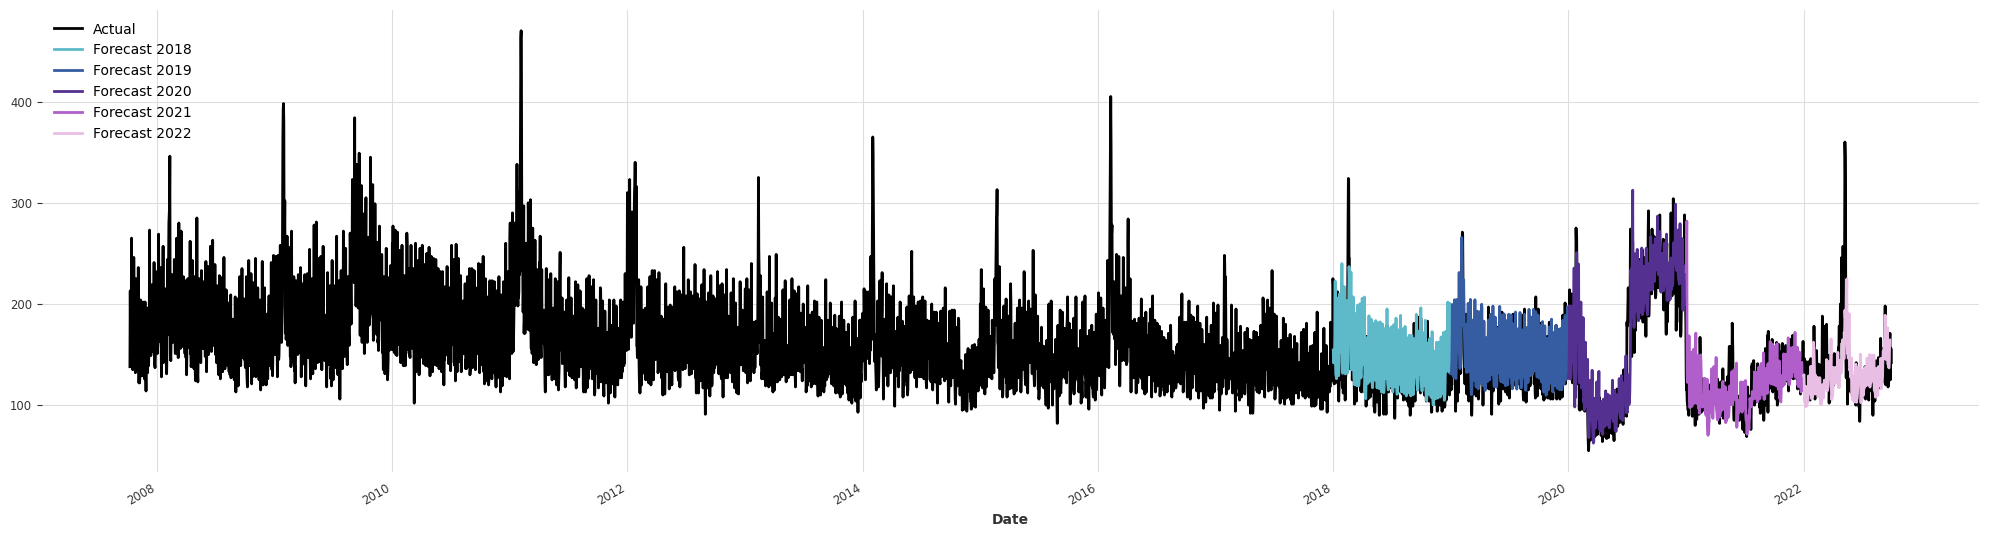

In [15]:
plt.figure(figsize=(25, 6))

# 绘制实际数据
combined_series.plot(label="Actual", color='black')

# 为2018到2022年的每个年份绘制预测数据
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']   # 为每个年份指定一个颜色
for i, year in enumerate(range(2018, 2023)):
    # 将DataArray转换回TimeSeries以便使用plot方法
    # 注意：这里假设yearly_dataarrays中存储的是DataArray对象
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])
    
    # 绘制每年的预测数据
    ts.plot(label=f"Forecast {year}", color=colors[i])

# 添加图例
plt.legend()

# 显示图表
plt.show()

#Save prediction

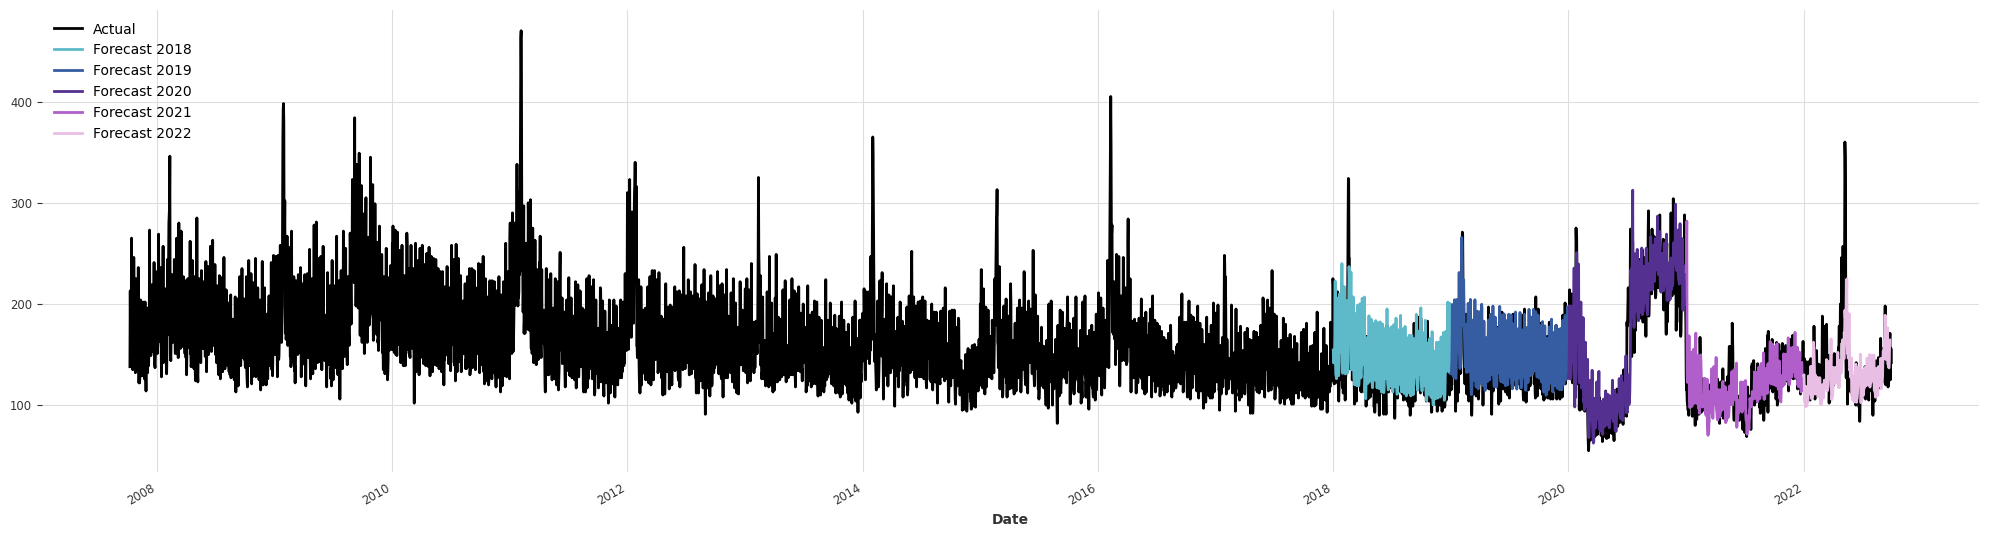

Forecast plot saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\LSTM\Taipei\Taipei_LSTM_FH7_forecast_plot.png
Metrics saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\LSTM\Taipei\Taipei_LSTM_FH7_metrics.txt
Model_prediction_df_inverse saved to C:\Users\ian11\Documents\GitHub\EDForecastCode\Result\LSTM\Taipei\Taipei_LSTM_FH7.csv


In [17]:
forecast_horizon_label = f"FH{forecast_horizon}"

# Define paths for the result files, using 'FH30' in the filenames
base_dir = os.path.abspath(os.path.join('..', 'Result', model_type, location))
plot_path = os.path.join(base_dir, f'{location}_{model_type}_{forecast_horizon_label}_forecast_plot.png')
metrics_txt_path = os.path.join(base_dir, f'{location}_{model_type}_{forecast_horizon_label}_metrics.txt')

# Ensure that the directories exist
os.makedirs(base_dir, exist_ok=True)

# Plot the actual and forecast data
plt.figure(figsize=(25, 6))

# Plot the actual data
combined_series.plot(label="Actual", color='black')

# Plot forecast data for each year (2018-2022)
colors = ['#5EB9C9', '#365DA1', '#543091', '#B05EC9', '#E9BEE5']
for i, year in enumerate(range(2018, 2023)):
    ts = TimeSeries.from_xarray(yearly_dataarrays[year])  # Convert DataArray to TimeSeries
    ts.plot(label=f"Forecast {year}", color=colors[i])

# Add legend
plt.legend()

# Save the plot to the specified path BEFORE displaying it
plt.savefig(plot_path, bbox_inches='tight')

# Now display the plot
plt.show()

# Print confirmation
print(f"Forecast plot saved to {plot_path}")

# Calculate metrics and save them
metrics_result = calculate_metrics(combined_series, yearly_dataarrays, APEdf, calculate_95_ci)

if metrics_result is not None:
    with open(metrics_txt_path, 'w') as f:
        # Write location, model_type, and forecast_horizon each on a new line
        f.write(f"Location: {location}\n")
        f.write(f"Model: {model_type}\n")
        f.write(f"Forecast Horizon: {forecast_horizon_label}\n\n")
        
        # Write header with aligned columns
        f.write(f"{'Period':<25} | {'MAE':<8} | {'MAPE':<8} | {'APE 95% CI':<20}\n")
        f.write("-" * 65 + "\n")  # Separator line
        
        # Write each period's metrics in a single line, aligned
        for period, metric in metrics_result.items():
            if isinstance(metric['APE 95% CI'], tuple):
                f.write(f"{period:<25} | {metric['MAE']:<8.2f} | {metric['MAPE']:<7.2f}% | "
                        f"({metric['APE 95% CI'][0]:.2f}, {metric['APE 95% CI'][1]:.2f})\n")
            else:
                f.write(f"{period:<25} | {metric['MAE']:<8.2f} | {metric['MAPE']:<7.2f}% | "
                        f"APE 95% CI: N/A\n")
                
    print(f"Metrics saved to {metrics_txt_path}")
else:
    print("Metrics calculation returned None, so nothing was saved.")

# Save Model_prediction_df_inverse to CSV
csv_filename = f"{location}_{model_type}_{forecast_horizon_label}.csv"
csv_filepath = os.path.join(base_dir, csv_filename)
Model_prediction_df_inverse.to_csv(csv_filepath, index=True)

# Print confirmation
print(f"Model_prediction_df_inverse saved to {csv_filepath}")

In [18]:
#combined_df = pd.concat([Model_prediction_df_inverse, APEdf], axis=1)

# 保存到 CSV 文件
#file_path = 'C:\\Users\\ian11\\EDtimeseriesForecast\\EDtimeseriesForecast\\Result\\LSTM\\Yunlin\\FH30.csv'
#combined_df.to_csv(file_path, index=True)